In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import seaborn as sns
import pickle
import random

from shapely.geometry import Point
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,median_absolute_error,max_error
from scipy.interpolate import LinearNDInterpolator, interp2d, BivariateSpline
from scipy.stats import skew
from collections import Counter

In [2]:
import WNN

Using TensorFlow backend.


In [3]:
import importlib
importlib.reload(WNN)

<module 'WNN' from 'C:\\Users\\students\\Desktop\\wrf_ml\\WNN.py'>

In [4]:
from WNN import WindNeuralNetwork,prepare_new_data,add_daymonth_and_sort

In [5]:
def get_stats(df,t_name='Power',p_name='Predicted_Power'):
    return {'R2':r2_score(df[t_name].values,df[p_name].values),
           'MAE' : mean_absolute_error(df[t_name].values,df[p_name].values),
           'RMSE' : np.sqrt(mean_squared_error(df[t_name].values,df[p_name].values)),
           'MedAE' : median_absolute_error(df[t_name].values,df[p_name].values),
           'ME' : max_error(df[t_name].values,df[p_name].values)}

def extract_months(dict_of_df,months,timename= 'Date-time'):
    output = {}
    for i in dict_of_df:
        output[i] = dict_of_df[i][dict_of_df[i][timename].apply(lambda x: x.month in months)]
    return output

### Load WRF Data

In [6]:
wt_list=['WTG01','WTG02','WTG03','WTG04','WTG05','WTG06','WTG07','WTG08','WTG09',
         'WTG10','WTG11','WTG12','WTG13','WTG14','WTG15','WTG16']
nominal_power = dict(zip(wt_list, 4*[2000]+4*[3300]+8*[2000]))

In [7]:
with open('wt_95_final.pickle', 'rb') as handle:
    df_95 = pickle.load(handle)
with open('wt_150_final.pickle', 'rb') as handle:
    df_150 = pickle.load(handle)

In [8]:
df_95['WTG01'].head()

Date-time                  Ws                Wdir  \
0 2019-06-10 09:00:00  3.8213380406315958  234.24475442920442   
0 2019-06-10 09:10:00   3.032147542820379  232.71074333452984   
0 2019-06-10 09:20:00  2.8881561225174286   235.8476647282395   
0 2019-06-10 09:30:00  2.8783832295518175   244.4965577468874   
0 2019-06-10 09:40:00  2.4958418099088826   249.4015346677861   

                    T                  P  
0   294.3506448437005  883.2411974960578  
0   294.9718062208258  884.1391936560981  
0  295.28616917647224  883.5835334906673  
0   295.5124789942895  883.0259440947316  
0   295.7229402529741   883.014433375523

In [9]:
for i in df_95:
    df_95[i]=add_daymonth_and_sort(df_95[i]).reset_index(drop=True)
for i in df_150:
    df_150[i]=add_daymonth_and_sort(df_150[i]).reset_index(drop=True)

### Load Juvent Data

In [10]:
df_juvent = pd.read_csv('Juvent_Data_2019_2020.csv')
df_juvent['Time'] = pd.to_datetime(df_juvent['Time'])

C:\Users\students\Anaconda3\envs\wnn\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
df_juvent.head()

Time  Turbine_id  Production  Power  Wind_Speed  \
0 2020-07-24 09:40:00          15      1027.0  248.0        20.0   
1 2020-07-24 09:40:00           9      1101.0  140.0        17.0   
2 2020-07-24 09:40:00          16      1554.0  391.0        23.0   
3 2020-07-24 09:40:00           8      1040.0  140.0        15.0   
4 2020-07-24 09:40:00           1      1043.0  210.0        18.0   

  Wind_Direction  Temperature  
0              W         16.0  
1              W         16.0  
2              W         16.0  
3              W         18.0  
4              W         16.0

### Merge both datasets for given chosen months

In [12]:
wt_95_all, wt_150_all = {},{}
for i,wt in enumerate(df_95,start = 1):
    wt_95_all[wt] = pd.merge(df_95[wt],df_juvent[df_juvent.Turbine_id == i],
                    left_on = 'Date-time',
                    right_on = 'Time',).drop(['Turbine_id','Time'],axis = 1)
    wt_150_all[wt] = pd.merge(df_150[wt],df_juvent[df_juvent.Turbine_id == i],
                    left_on = 'Date-time',
                    right_on = 'Time',).drop(['Turbine_id','Time'],axis = 1)

In [13]:
wt_95_all[wt].head()

Date-time                 Ws                Wdir  \
0 2020-07-21 03:00:00    7.7589005306996  231.83912426131985   
1 2020-07-21 02:50:00  7.598729550372616  240.18902340807702   
2 2020-07-21 02:40:00   7.40161960851656  243.12351195003802   
3 2020-07-21 02:30:00  7.402729518249467  233.97941327170452   
4 2020-07-21 02:20:00  7.331699875326263  232.08396184121005   

                    T                  P Day_Month  Production  Power  \
0  301.96936459198446  889.4287285775886      21_7       -20.0    0.0   
1  301.98190296387713   889.433225444358      21_7       -20.0    0.0   
2  302.04241602726916   889.391755139078      21_7       -20.0  -28.0   
3   302.1580337233968  889.3791196110772      21_7       -15.0    0.0   
4   302.4039500330704  889.4311508587598      21_7       -15.0    0.0   

   Wind_Speed Wind_Direction  Temperature  
0        11.0             SO         20.0  
1         9.0              O         19.0  
2         8.0             SO         19.0  
3         8.0             SO         20.0  
4         8.0             SO         19.0

### Remove days with less than 50 measurements (heavily incomplete days)

In [14]:
for wt in wt_list:
    tmp = Counter(wt_95_all[wt].Day_Month)
    ic_day = [i for i,j in zip(tmp.keys(),tmp.values()) if j < 50]
    wt_95_all[wt] = wt_95_all[wt][wt_95_all[wt].Day_Month.apply(lambda x : x not in ic_day)]
    wt_150_all[wt] = wt_150_all[wt][wt_150_all[wt].Day_Month.apply(lambda x : x not in ic_day)]
    print(len(ic_day))

11
2
4
6
5
8
3
10
4
4
7
3
6
6
5
9


### The outlier problem in  wind speed-power curves
many power values at 0 or extremly low even at high wind speeds

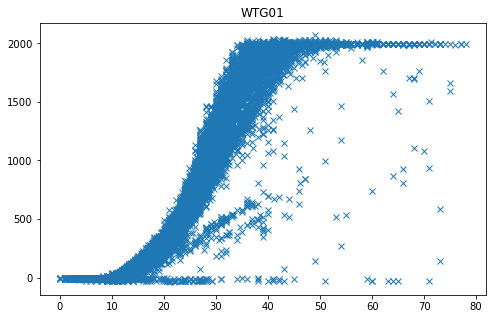

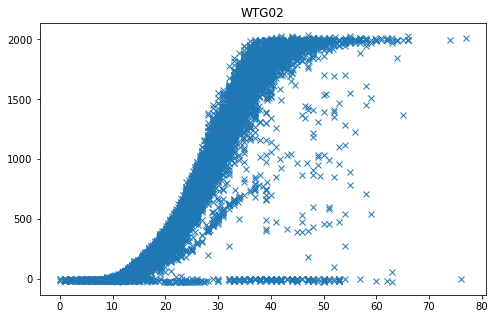

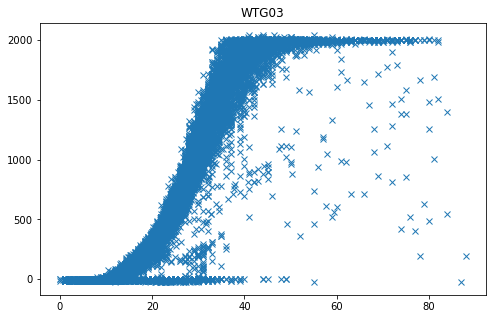

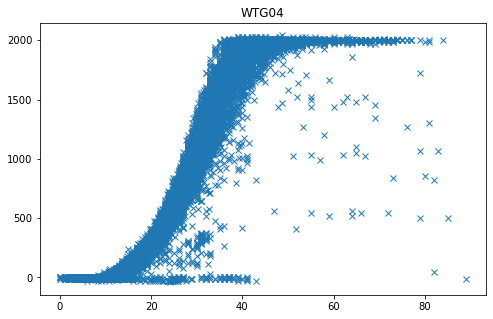

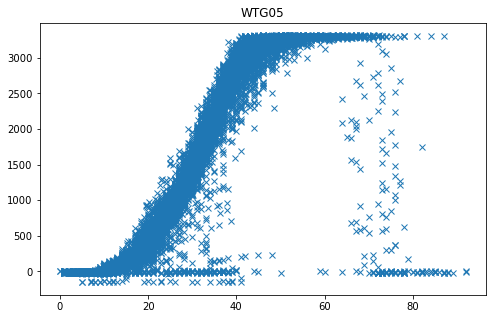

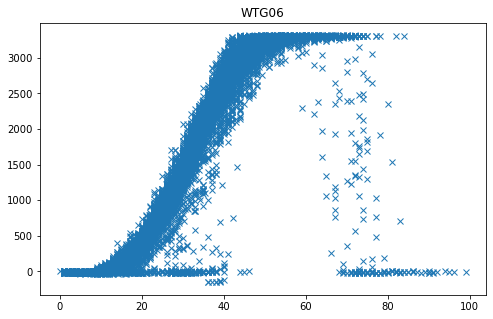

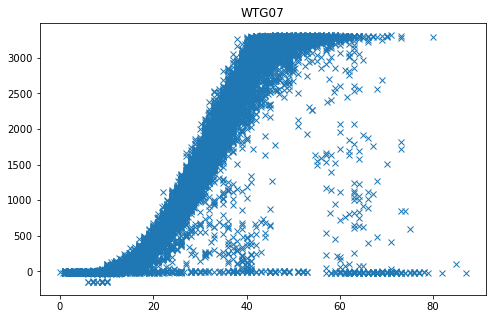

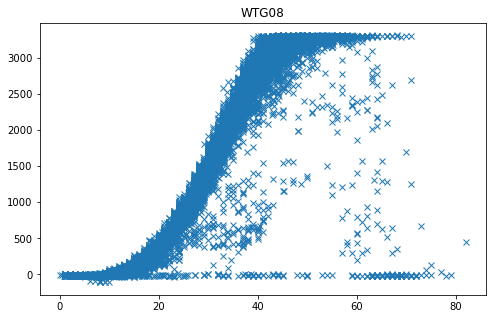

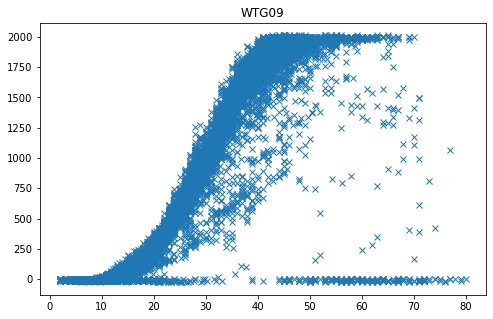

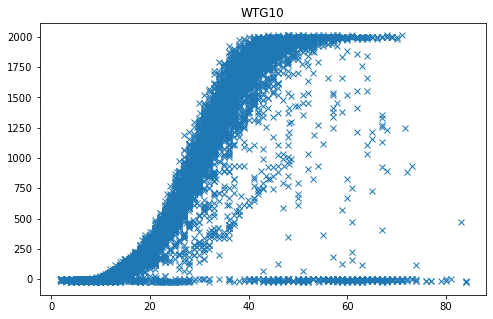

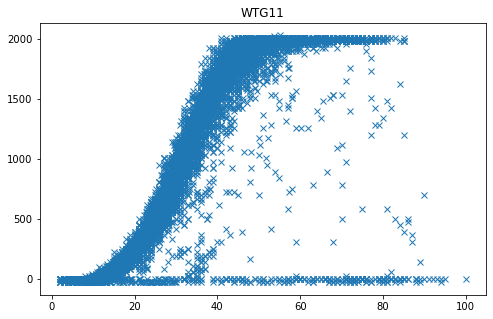

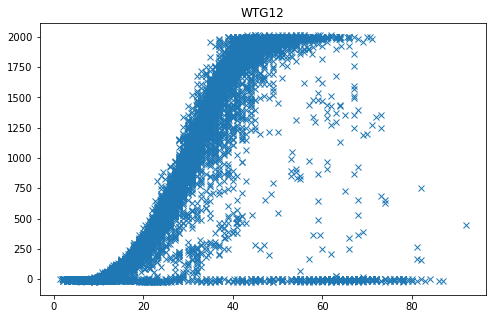

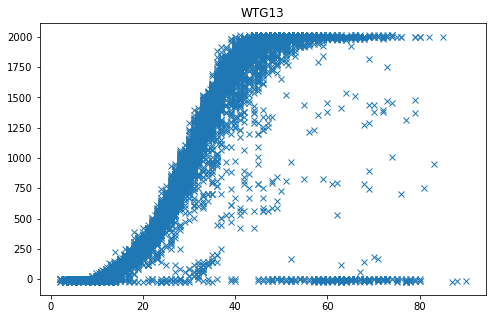

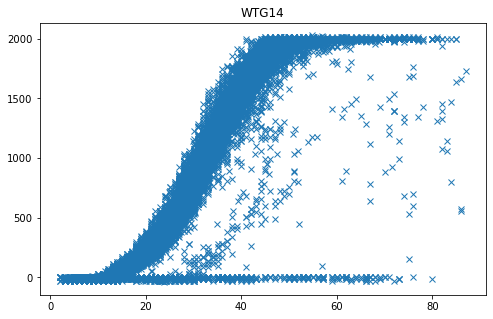

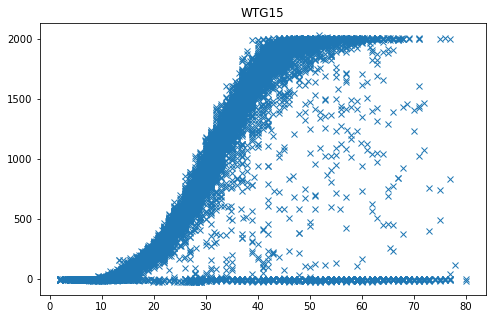

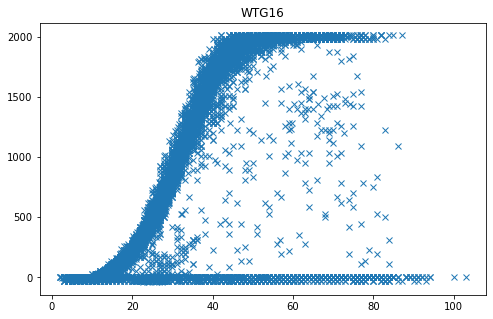

In [15]:
for wt in wt_list:
    fig,ax = plt.subplots(figsize=(8,5))
    plt.plot(wt_95_all[wt].Wind_Speed.values,wt_95_all[wt].Power.values,'x')
    plt.title(wt)
    plt.show()

### lets fit a curve to eliminate erroneous values

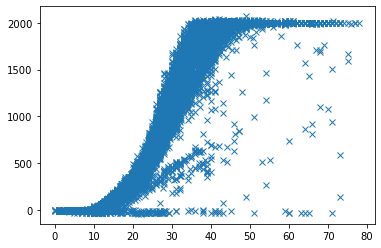

In [16]:
df_aux = wt_95_all['WTG01'].copy()
plt.plot(df_aux.Wind_Speed.values,df_aux.Power.values,'x')

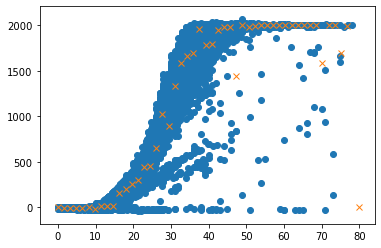

In [17]:
# Interpolation, works but not great. 
df_aux = df_aux.sort_values(by='Wind_Speed')
p_interp = np.interp(np.linspace(0,80),df_aux['Wind_Speed'].values,df_aux['Power'].values)
plt.plot(np.linspace(0,80),p_interp,'xC1')
plt.scatter(df_aux['Wind_Speed'].values,df_aux['Power'].values)

In [18]:
from operational_analysis.toolkits.power_curve.functions import logistic_5_parametric,gam,IEC

In [19]:
df_aux = df_aux.dropna()

In [20]:
lpc = logistic_5_parametric(df_aux['Wind_Speed'],df_aux['Power'])
gpc = gam(df_aux['Wind_Speed'],df_aux['Power'],n_splines=15)
iec = IEC(df_aux['Wind_Speed'],df_aux['Power'],windspeed_end=90.0)

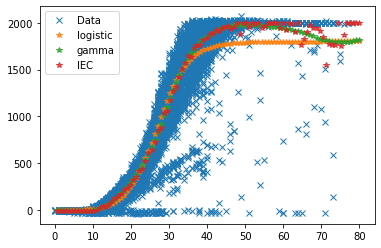

In [21]:
ws_xx = np.linspace(0.5,80,num = 100)

plt.plot(df_aux['Wind_Speed'].values,df_aux['Power'].values,'x',label = 'Data')
plt.plot(ws_xx,lpc(ws_xx),'*',alpha = 0.8,label = 'logistic')
plt.plot(ws_xx,gpc(ws_xx),'*',alpha = 0.8,label = 'gamma')
plt.plot(ws_xx,iec(ws_xx),'*',alpha = 0.8,label = 'IEC')
plt.legend()
plt.show()

In [22]:
## now lets stablish an outlier detection method
def wind_outlier(f,ws,power,w_start = 0.01, w_end = 80, p_start = 0, p_end = 2000,num = 50, alpha = 0.15):
    """
    return 0 if outlier
           1 if not 
    """
    
    ws_xx = np.linspace(w_start,w_end,num)
    p_yy = f(ws_xx)/p_end
    ws_xx = ws_xx/w_end
    outlier = []
    for a,b in zip(ws,power):
        min_dist = np.inf
        for i,j in zip(ws_xx,p_yy):
            tmp = np.sqrt((i-a/w_end)**2 + (j-b/p_end)**2)
            if min_dist > tmp:
                min_dist = tmp
        if min_dist < alpha:
            outlier.append(1)
        else:
            outlier.append(0)
    return outlier

In [23]:
outliers = wind_outlier(lpc,df_aux['Wind_Speed'].values,df_aux['Power'].values,alpha = 0.2)

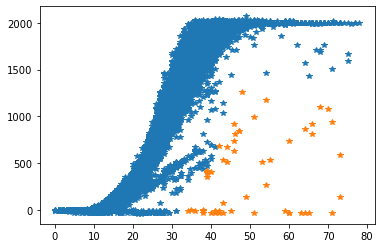

In [24]:
plt.plot(df_aux[np.array(outliers,dtype=bool)].Wind_Speed.values,df_aux[np.array(outliers,dtype=bool)].Power.values,'*')
plt.plot(df_aux[~np.array(outliers,dtype=bool)].Wind_Speed.values,df_aux[~np.array(outliers,dtype=bool)].Power.values,'*')

### Outlier detection looks good now
we can apply it to the entire dataset, we use a two stage outlier detection

In [25]:
nominal_power[wt]

2000

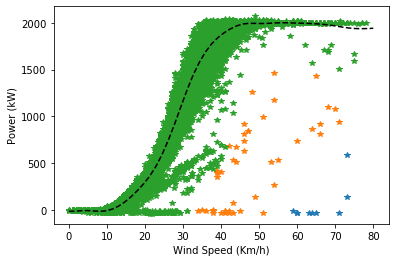

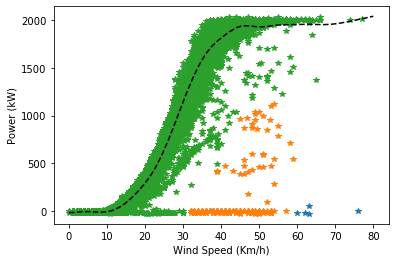

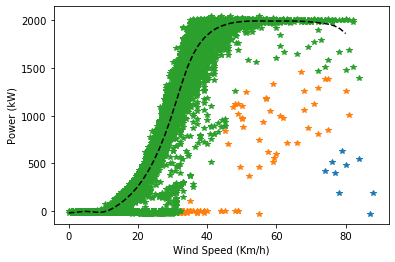

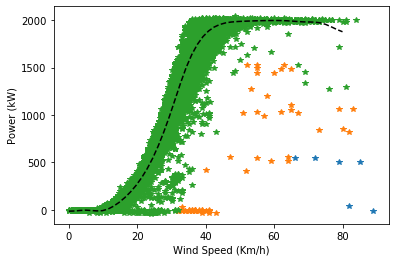

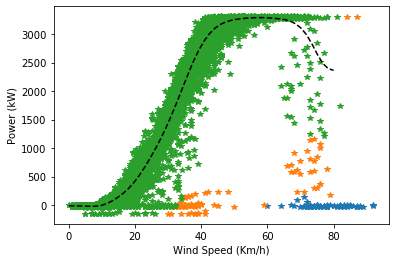

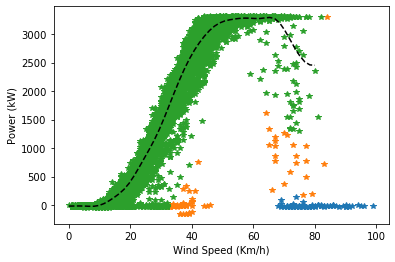

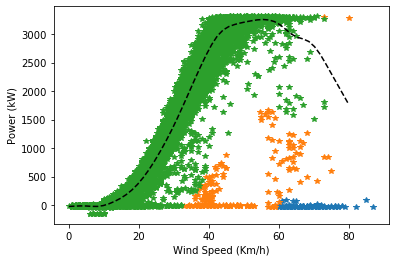

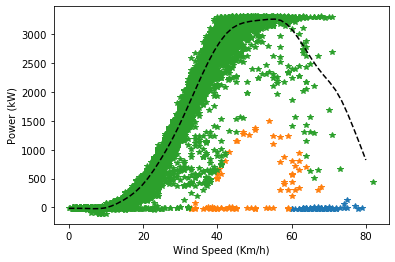

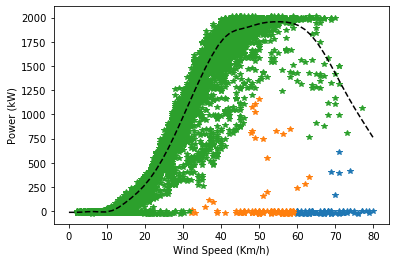

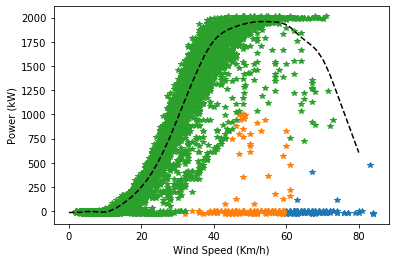

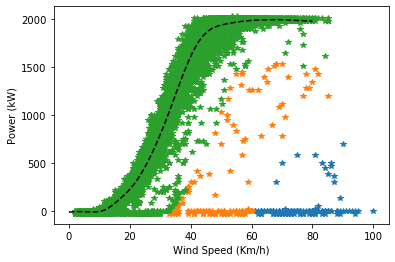

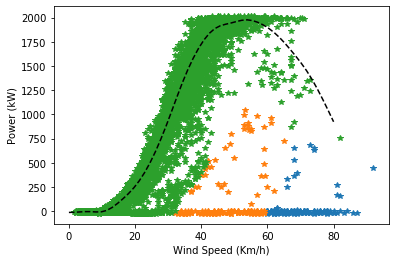

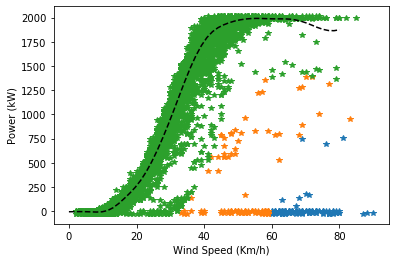

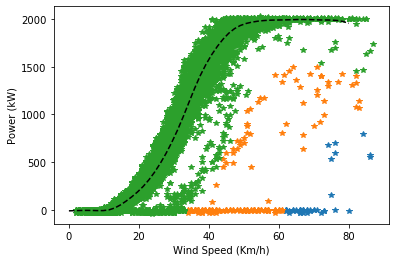

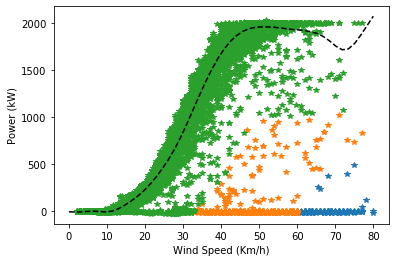

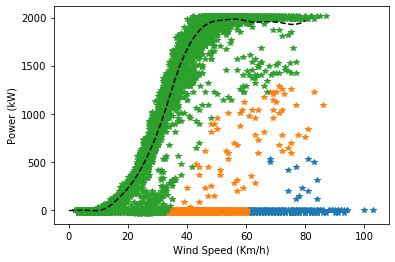

In [152]:
wt_95_all_filtered,wt_150_all_filtered = {},{}
for wt in wt_list:
    
    fig,ax = plt.subplots(figsize=(6,4))
    df_aux = wt_95_all[wt].dropna()
    df_aux2 = wt_150_all[wt].dropna()

    gpc = logistic_5_parametric(df_aux['Wind_Speed'],df_aux['Power'])
    outliers = wind_outlier(gpc,df_aux['Wind_Speed'].values,df_aux['Power'].values,
                            p_end = nominal_power[wt],alpha = 0.5)

    plt.plot(df_aux[~np.array(outliers,dtype=bool)].Wind_Speed.values,
             df_aux[~np.array(outliers,dtype=bool)].Power.values,'*')

    df_aux = df_aux[np.array(outliers,dtype=bool)]
    df_aux2 = df_aux2[np.array(outliers,dtype=bool)]
    
    gpc = gam(df_aux['Wind_Speed'],df_aux['Power'])
    outliers = wind_outlier(gpc,df_aux['Wind_Speed'].values,df_aux['Power'].values,
                            p_end = nominal_power[wt],alpha = 0.2)

    plt.plot(df_aux[~np.array(outliers,dtype=bool)].Wind_Speed.values,
             df_aux[~np.array(outliers,dtype=bool)].Power.values,'*')

    df_aux = df_aux[np.array(outliers,dtype=bool)]
    df_aux2 = df_aux2[np.array(outliers,dtype=bool)]    
    
    plt.xlabel('Wind Speed (Km/h)')
    plt.ylabel('Power (kW)')
    
    plt.plot(df_aux.Wind_Speed.values,df_aux.Power.values,'*')
    
    gpc = gam(df_aux['Wind_Speed'],df_aux['Power'])
    
    plt.plot(np.linspace(0,80),gpc(np.linspace(0,80)),'k--',)
    
    wt_95_all_filtered[wt] = df_aux
    wt_150_all_filtered[wt] = df_aux2
    plt.show()
    
    if wt == 'WTG10':
        fig.savefig('outlier_wspc.pdf',bbox_inches='tight')

In [27]:
for wt in wt_list: # again remove incomplete days due to outlier deletion
    tmp = Counter(wt_95_all_filtered[wt].Day_Month)
    ic_day = [i for i,j in zip(tmp.keys(),tmp.values()) if j < 50]
    wt_95_all_filtered[wt] = wt_95_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x : x not in ic_day)]
    wt_150_all_filtered[wt] = wt_150_all_filtered[wt][wt_150_all_filtered[wt].Day_Month.apply(lambda x : x not in ic_day)]
    print(len(ic_day))

0
0
0
0
0
0
0
1
0
2
1
1
1
0
2
8


### Now that the data is in order, we can fit the forecast model
First we extract a validation set from the data, four entire days per month selected randomly. the remaning data will be split into training and testing set by the NN, we dont have to do that manually.

In [28]:
month_days_dict = {}
month_days_test = []
for m in range(1,13):
    month_days_dict[m] = []
    for s in wt_95_all_filtered['WTG01'].Day_Month.unique():
        if int(s.split('_')[1]) == m:
            month_days_dict[m].append(s.split('_')[0])
    for i in random.sample(range(0, len(month_days_dict[m])), 4):
        month_days_test.append(str(m)+'_'+str(month_days_dict[m][i]))

In [29]:
#save the desired run so that we can reproduce the results
month_days_test =['1_5','1_9','1_10','1_19','2_5','2_3','2_18','2_4','3_26','3_18','3_21','3_13','4_23','4_7',
 '4_21','4_4','5_14','5_20','5_24','5_17','6_21','6_2','6_16','6_18','7_26','7_16','7_21','7_19','8_24','8_6',
 '8_4','8_5','9_10','9_7','9_20','9_13','10_24','10_5','10_4','10_13','11_28','11_25','11_7','11_10','12_3',
 '12_16','12_21','12_1']

In [30]:
#split the data
wt_95_retrain, wt_95_test,wt_150_retrain, wt_150_test = {},{},{},{}
for wt in wt_list:
    wt_95_retrain[wt]  = wt_95_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x not in month_days_test)]
    wt_95_test[wt]     = wt_95_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x in month_days_test)]
    wt_150_retrain[wt] = wt_150_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x not in month_days_test)]
    wt_150_test[wt]    = wt_150_all_filtered[wt][wt_95_all_filtered[wt].Day_Month.apply(lambda x: x in month_days_test)]

#### Now we can train the NN with the desired parameters

In [81]:
wnn_dict = {}
all_stats = {}
for wt in wt_list:
    print('----------------------')
    print('------  '+wt+'  ------')
    print('----------------------')
    wnn = WNN.WindNeuralNetwork(wt_95_retrain[wt],wt_150_retrain[wt],var = 'Power',
                                features=['Ws', 'Wdir', 'T','P'],
                                look_back=12,
                                time_jump=1,
                                q_weight=1.55,
                                quantile=0.55,
                                include_tanh = True,
                                patience = 2,
                                epochs = 45,
                                scaler = 'Standard') #Initialize it with the loaded data
    wnn.prep_data()#Prepare the data
    wnn.create_and_fit_model(verbose = 1)  # Create and fit the model  you can set verbose to 1 to see the training evolution
    wnn.predict_and_getmetrics_test()
    print(wnn.stats)
    all_stats[wt] = wnn.stats
    wnn_dict[wt] = wnn

----------------------
------  WTG01  ------
----------------------
Train on 25551 samples, validate on 4509 samples
Epoch 1/45
25551/25551 [==============================] - 1s 47us/step - loss: 0.3607 - val_loss: 0.3160
Epoch 2/45
25551/25551 [==============================] - 1s 42us/step - loss: 0.3264 - val_loss: 0.3211
Epoch 3/45
25551/25551 [==============================] - 1s 42us/step - loss: 0.3153 - val_loss: 0.2989
Epoch 4/45
25551/25551 [==============================] - 1s 41us/step - loss: 0.3061 - val_loss: 0.3421
Epoch 5/45
25551/25551 [==============================] - 1s 41us/step - loss: 0.2970 - val_loss: 0.2798
Epoch 6/45
25551/25551 [==============================] - 1s 41us/step - loss: 0.2902 - val_loss: 0.2782
Epoch 7/45
25551/25551 [==============================] - 1s 41us/step - loss: 0.2842 - val_loss: 0.2762
Epoch 8/45
25551/25551 [==============================] - 1s 40us/step - loss: 0.2771 - val_loss: 0.2774
Epoch 9/45
25551/25551 [===================

25568/25568 [==============================] - 1s 40us/step - loss: 0.2129 - val_loss: 0.2025
Epoch 17/45
25568/25568 [==============================] - 1s 40us/step - loss: 0.2089 - val_loss: 0.1948
Epoch 18/45
25568/25568 [==============================] - 1s 40us/step - loss: 0.2044 - val_loss: 0.2056
Epoch 19/45
25568/25568 [==============================] - 1s 40us/step - loss: 0.1990 - val_loss: 0.1964
[0.853814909012263, 168.13000938282877, 65145.07955800731, 101.59223360175451, 1853.927821512198]
----------------------
------  WTG05  ------
----------------------
Train on 25676 samples, validate on 4532 samples
Epoch 1/45
25676/25676 [==============================] - 1s 45us/step - loss: 0.3596 - val_loss: 0.3134
Epoch 2/45
25676/25676 [==============================] - 1s 39us/step - loss: 0.3214 - val_loss: 0.3057
Epoch 3/45
25676/25676 [==============================] - 1s 38us/step - loss: 0.3134 - val_loss: 0.3046
Epoch 4/45
25676/25676 [==============================] - 

25614/25614 [==============================] - 1s 45us/step - loss: 0.3751 - val_loss: 0.3697
Epoch 3/45
25614/25614 [==============================] - 1s 45us/step - loss: 0.3543 - val_loss: 0.3955
Epoch 4/45
25614/25614 [==============================] - 1s 45us/step - loss: 0.3384 - val_loss: 0.3593
Epoch 5/45
25614/25614 [==============================] - 1s 45us/step - loss: 0.3279 - val_loss: 0.3330
Epoch 6/45
25614/25614 [==============================] - 1s 45us/step - loss: 0.3134 - val_loss: 0.3408
Epoch 7/45
25614/25614 [==============================] - 1s 44us/step - loss: 0.3061 - val_loss: 0.3085
Epoch 8/45
25614/25614 [==============================] - 1s 44us/step - loss: 0.2983 - val_loss: 0.3187
Epoch 9/45
25614/25614 [==============================] - 1s 44us/step - loss: 0.2886 - val_loss: 0.3145
[0.786430929227724, 204.89536986130548, 78522.13152792853, 144.68113716380867, 1756.6700040015892]
----------------------
------  WTG10  ------
----------------------
Trai

25143/25143 [==============================] - 1s 41us/step - loss: 0.3597 - val_loss: 0.3381
Epoch 3/45
25143/25143 [==============================] - 1s 41us/step - loss: 0.3432 - val_loss: 0.3408
Epoch 4/45
25143/25143 [==============================] - 1s 41us/step - loss: 0.3341 - val_loss: 0.3312
Epoch 5/45
25143/25143 [==============================] - 1s 41us/step - loss: 0.3199 - val_loss: 0.3149
Epoch 6/45
25143/25143 [==============================] - 1s 41us/step - loss: 0.3090 - val_loss: 0.3066
Epoch 7/45
25143/25143 [==============================] - 1s 41us/step - loss: 0.2985 - val_loss: 0.2908
Epoch 8/45
25143/25143 [==============================] - 1s 41us/step - loss: 0.2906 - val_loss: 0.2939
Epoch 9/45
25143/25143 [==============================] - 1s 41us/step - loss: 0.2861 - val_loss: 0.2889
Epoch 10/45
25143/25143 [==============================] - 1s 41us/step - loss: 0.2784 - val_loss: 0.2865
Epoch 11/45
25143/25143 [==============================] - 1s 41u

In [82]:
## Save the trained models
#with open('wnn_dict_final.pickle', 'wb') as handle:
#    pickle.dump(wnn_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### use the NN trained above to predict the validation set

------  WTG01  ------
MAE = 11.13
RMSE = 17.01
MedAE = 6.15
ME = 91.72


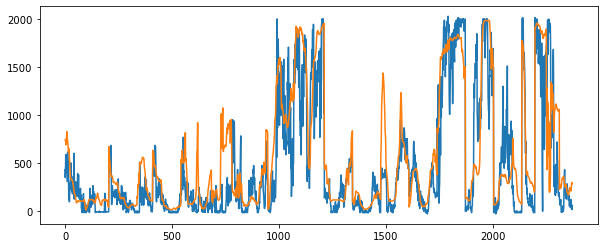

------  WTG02  ------
MAE = 10.4
RMSE = 14.93
MedAE = 6.81
ME = 64.6


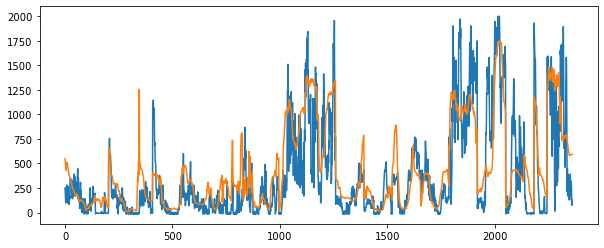

------  WTG03  ------
MAE = 11.95
RMSE = 18.66
MedAE = 6.93
ME = 88.36


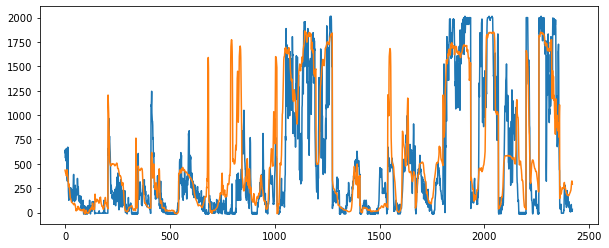

------  WTG04  ------
MAE = 12.64
RMSE = 19.12
MedAE = 7.11
ME = 70.97


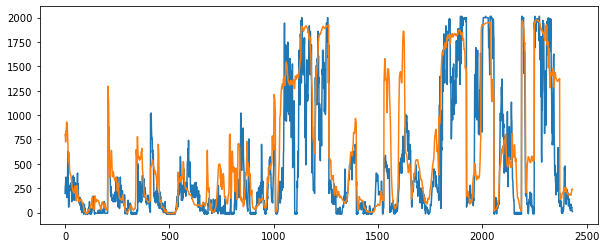

------  WTG05  ------
MAE = 13.29
RMSE = 20.06
MedAE = 7.61
ME = 91.07


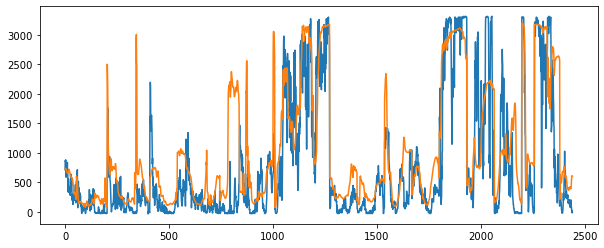

------  WTG06  ------
MAE = 11.6
RMSE = 17.87
MedAE = 6.55
ME = 74.64


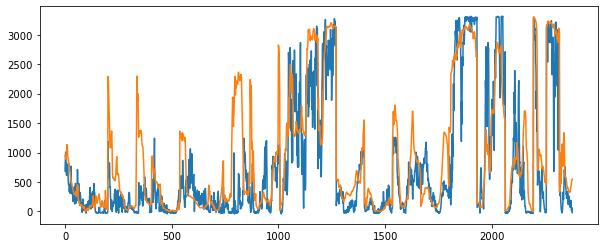

------  WTG07  ------
MAE = 11.82
RMSE = 18.65
MedAE = 6.56
ME = 80.38


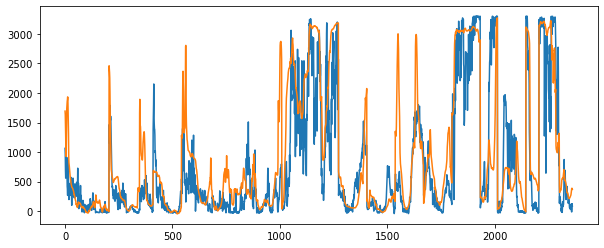

------  WTG08  ------
MAE = 10.45
RMSE = 15.77
MedAE = 6.46
ME = 84.21


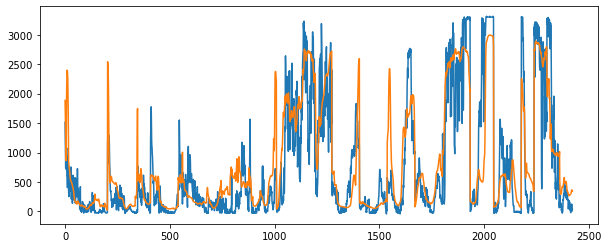

------  WTG09  ------
MAE = 12.32
RMSE = 17.35
MedAE = 8.55
ME = 81.89


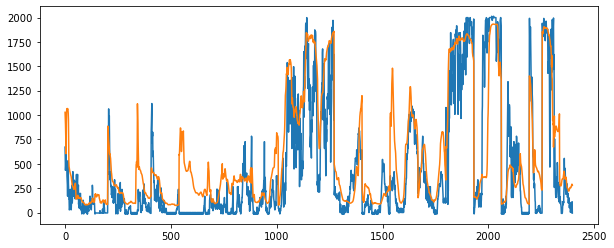

------  WTG10  ------
MAE = 9.99
RMSE = 14.67
MedAE = 6.24
ME = 77.59


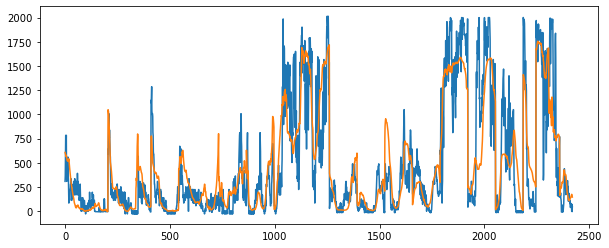

------  WTG11  ------
MAE = 12.34
RMSE = 18.64
MedAE = 6.91
ME = 92.2


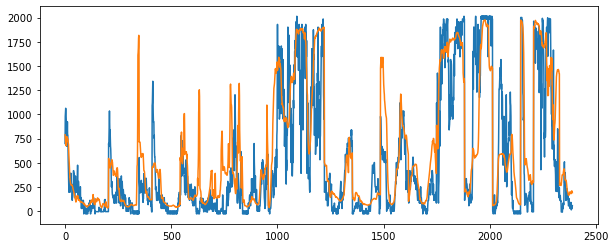

------  WTG12  ------
MAE = 10.78
RMSE = 16.22
MedAE = 6.31
ME = 86.09


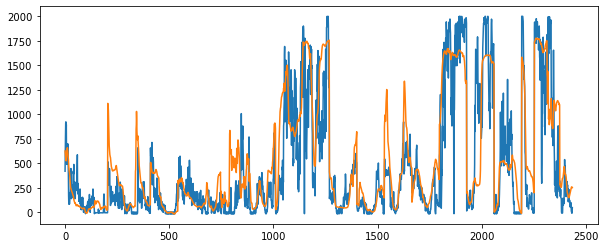

------  WTG13  ------
MAE = 12.39
RMSE = 19.17
MedAE = 6.93
ME = 86.21


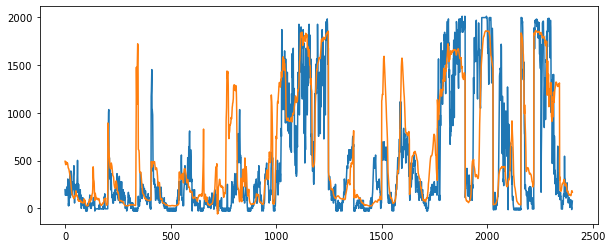

------  WTG14  ------
MAE = 14.04
RMSE = 21.29
MedAE = 7.82
ME = 88.19


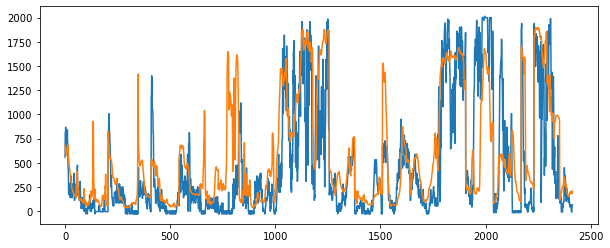

------  WTG15  ------
MAE = 12.84
RMSE = 18.96
MedAE = 7.66
ME = 93.72


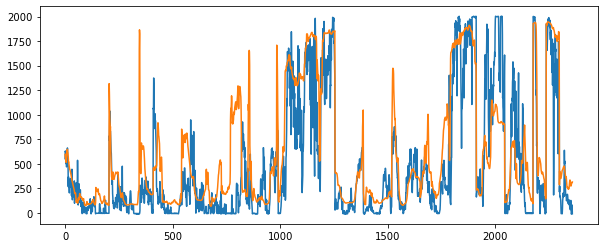

------  WTG16  ------
MAE = 11.13
RMSE = 16.27
MedAE = 7.27
ME = 80.9


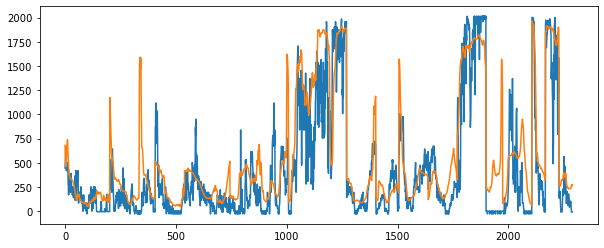

In [83]:
val_stats={}
for wt in wt_list:
    print('------  '+wt+'  ------')
    dfout = wnn_dict[wt].predict_new_data(wt_95_test[wt],wt_150_test[wt])
    stats = get_stats(dfout)
    val_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        val_stats[wt].append(100*stats[i]/nominal_power[wt])
        print(i +' = '+ str(np.round(val_stats[wt][-1],2)))
        
    fig,ax = plt.subplots(figsize=(10,4))
    plt.plot(dfout.Power.values)
    plt.plot(dfout.Predicted_Power.values)
    plt.show()

In [126]:
wnn_dict['WTG01'].model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_449 (Dense)            (None, 104)               10920     
_________________________________________________________________
dense_450 (Dense)            (None, 69)                7245      
_________________________________________________________________
dense_451 (Dense)            (None, 69)                4830      
_________________________________________________________________
dropout_65 (Dropout)         (None, 69)                0         
_________________________________________________________________
dense_452 (Dense)            (None, 52)                3640      
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 52)                0         
_________________________________________________________________
dense_453 (Dense)            (None, 52)              

------  WTG01  ------
MAE = 11.13
RMSE = 17.01
MedAE = 6.15
ME = 91.72


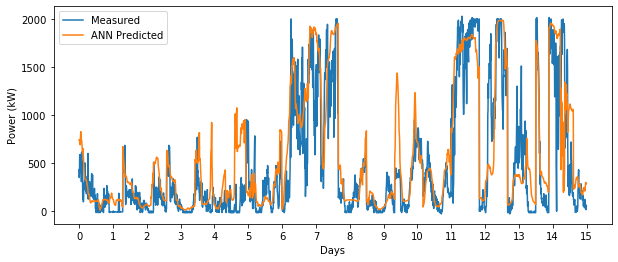

------  WTG02  ------
MAE = 10.4
RMSE = 14.93
MedAE = 6.81
ME = 64.6


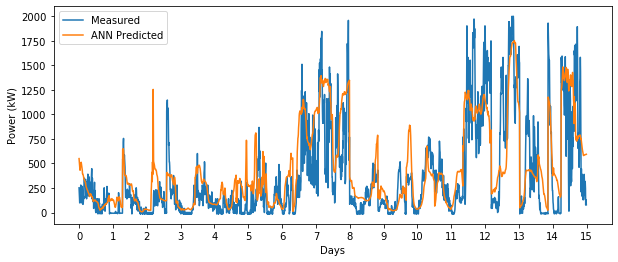

------  WTG03  ------
MAE = 11.95
RMSE = 18.66
MedAE = 6.93
ME = 88.36


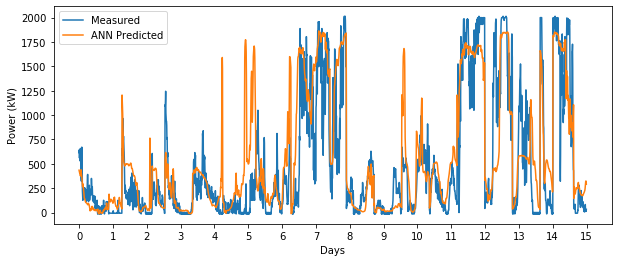

------  WTG04  ------
MAE = 12.64
RMSE = 19.12
MedAE = 7.11
ME = 70.97


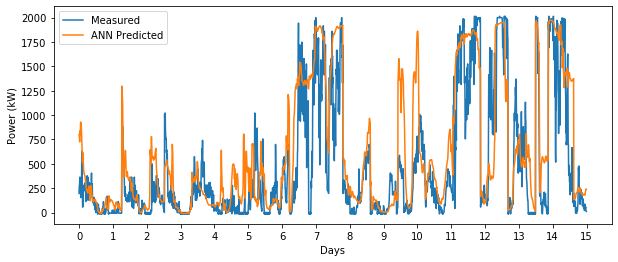

------  WTG05  ------
MAE = 13.29
RMSE = 20.06
MedAE = 7.61
ME = 91.07


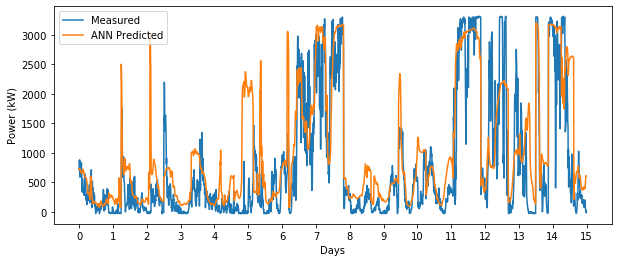

------  WTG06  ------
MAE = 11.6
RMSE = 17.87
MedAE = 6.55
ME = 74.64


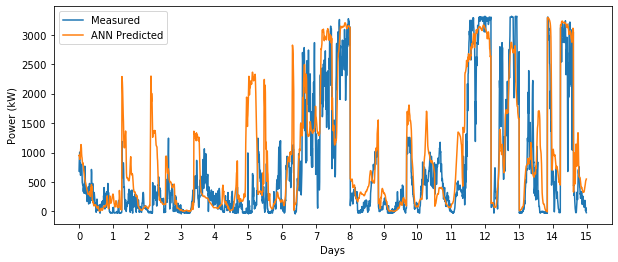

------  WTG07  ------
MAE = 11.82
RMSE = 18.65
MedAE = 6.56
ME = 80.38


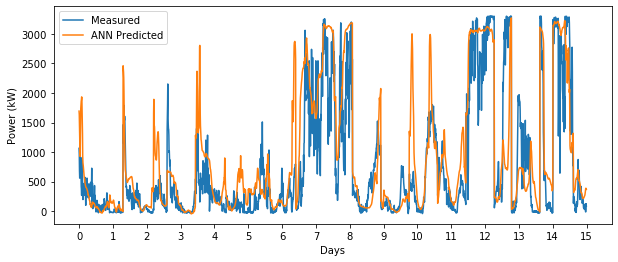

------  WTG08  ------
MAE = 10.45
RMSE = 15.77
MedAE = 6.46
ME = 84.21


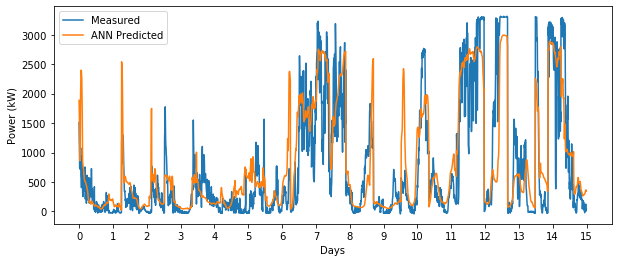

------  WTG09  ------
MAE = 12.32
RMSE = 17.35
MedAE = 8.55
ME = 81.89


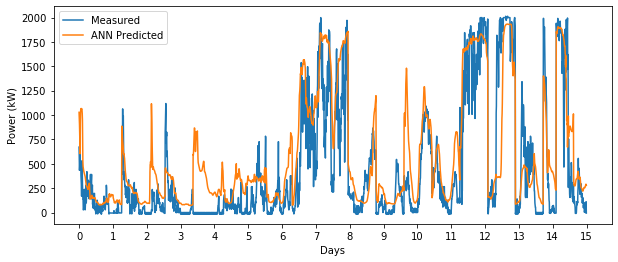

------  WTG10  ------
MAE = 9.99
RMSE = 14.67
MedAE = 6.24
ME = 77.59


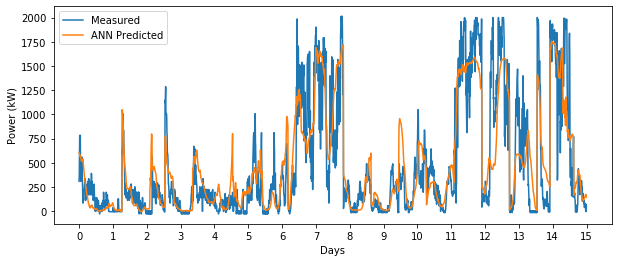

------  WTG11  ------
MAE = 12.34
RMSE = 18.64
MedAE = 6.91
ME = 92.2


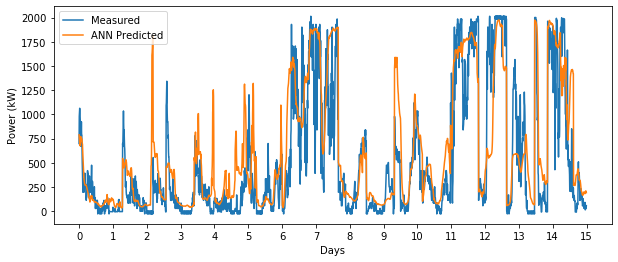

------  WTG12  ------
MAE = 10.78
RMSE = 16.22
MedAE = 6.31
ME = 86.09


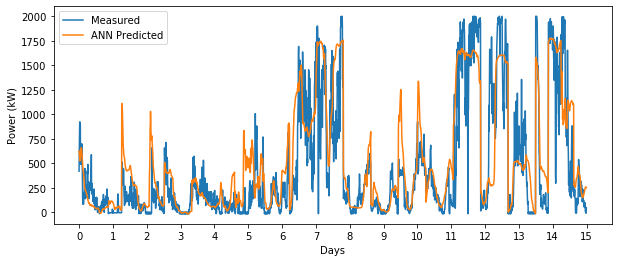

------  WTG13  ------
MAE = 12.39
RMSE = 19.17
MedAE = 6.93
ME = 86.21


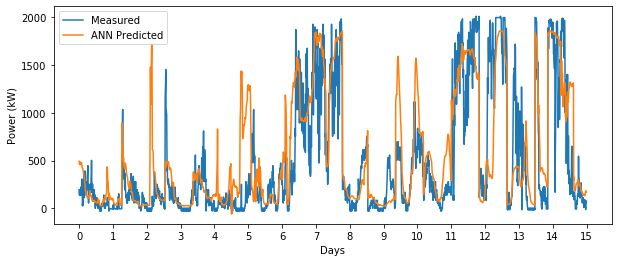

------  WTG14  ------
MAE = 14.04
RMSE = 21.29
MedAE = 7.82
ME = 88.19


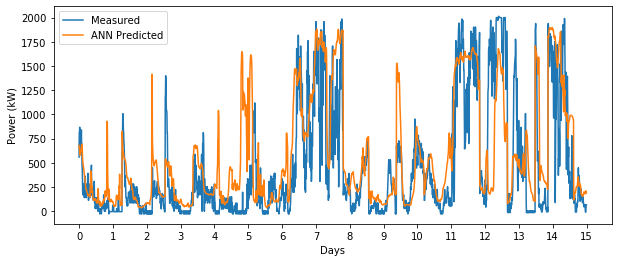

------  WTG15  ------
MAE = 12.84
RMSE = 18.96
MedAE = 7.66
ME = 93.72


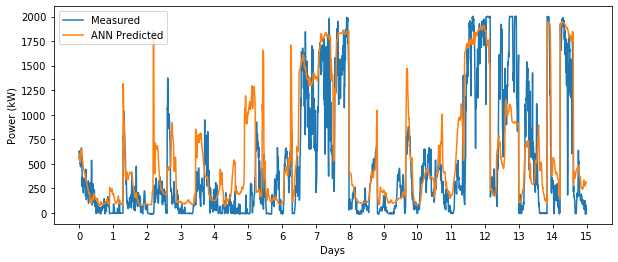

------  WTG16  ------
MAE = 11.13
RMSE = 16.27
MedAE = 7.27
ME = 80.9


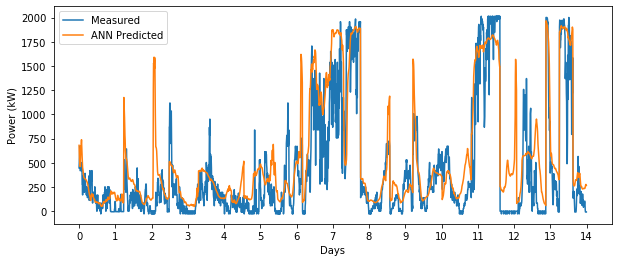

In [178]:
val_stats={}
for wt in wt_list:
    print('------  '+wt+'  ------')
    dfout = wnn_dict[wt].predict_new_data(wt_95_test[wt],wt_150_test[wt])
    stats = get_stats(dfout)
    val_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        val_stats[wt].append(100*stats[i]/nominal_power[wt])
        print(i +' = '+ str(np.round(val_stats[wt][-1],2)))
    
    fig,ax = plt.subplots(figsize=(10,4))
    plt.plot(dfout.Power.values,label = 'Measured')
    plt.plot(dfout.Predicted_Power.values,label = 'ANN Predicted')
    
    xaux = np.arange(0,np.floor(len(dfout.Predicted_Power.values)/(24*6)))
    ax.set_xticks(np.linspace(0,len(dfout.Predicted_Power.values),len(xaux)))
    ax.set_xticklabels([int(i) for i in xaux])
    
    plt.xlabel('Days')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.show()
    #if wt == 'WTG10':
    #    fig.savefig('forecast_timeplot.pdf',bbox_inches='tight')

In [208]:
dfout['dmh'] = dfout['Date-time'].dt.strftime('%m%d%H')

In [214]:
df12 = dfout.groupby('dmh').mean()

In [211]:
stats_h = get_stats(dfout.groupby('dmh').mean())

In [215]:
tmp = []
for i in list(stats_h.keys())[1:]:
        tmp.append(100*stats_h[i]/nominal_power[wt])
        print(i +' = '+ str(np.round(tmp[-1],2)))

MAE = 10.77
RMSE = 15.63
MedAE = 7.28
ME = 65.85


#### Normalize prediction statistics by the nominal power of the wind turbines

In [85]:
for wt in all_stats:  # convert stats into percentge except for R2
    tmp = all_stats[wt]
    tmp[2] = np.sqrt(tmp[2])
    all_stats[wt] = [tmp[0]] + [100*i / nominal_power[wt] for i in tmp[1:]]

In [86]:
df = pd.DataFrame(all_stats)
df_val = pd.DataFrame(val_stats)

In [87]:
def autolabel(ax,rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(np.round(height,1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    return ax
        
        
def bar_metrics(x1,x2,labels,ylabel,title,width = 0.35,loc = 3,figsize=(14,5)):
    fig,ax = plt.subplots(figsize=figsize)
    xx = np.arange(len(labels))  # the label locations
      # the width of the bars

    rects1 = ax.bar(xx - width/2, x1, width, label='Test Set')
    rects2 = ax.bar(xx + width/2, x2, width, label='Validation Set')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel,fontsize = 14)
    ax.set_title(title)
    ax.set_xticks(xx)
    ax.set_xticklabels(labels)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.legend(loc = loc)
    ax = autolabel(ax,rects1)
    ax = autolabel(ax,rects2)
    plt.show()
    return fig, ax

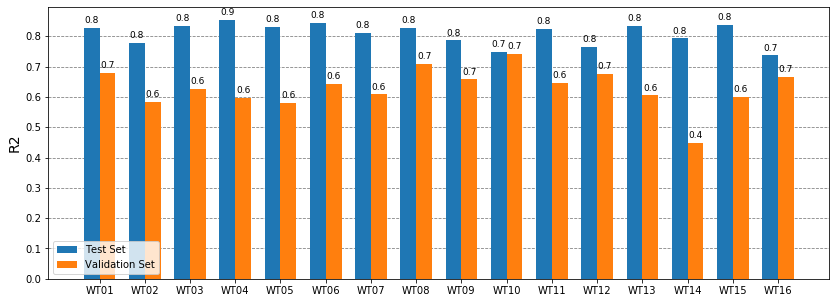

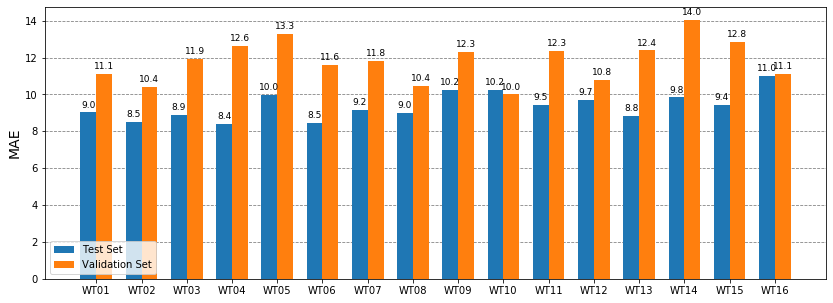

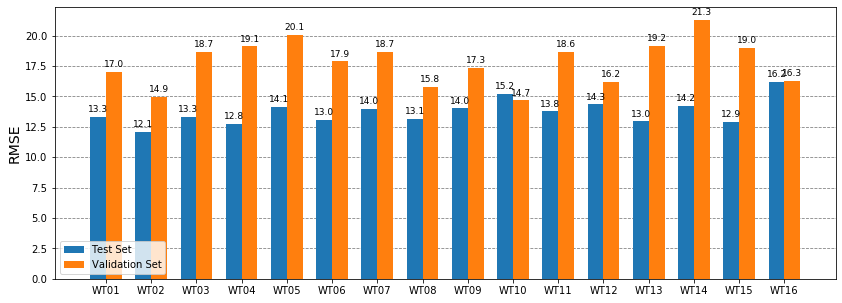

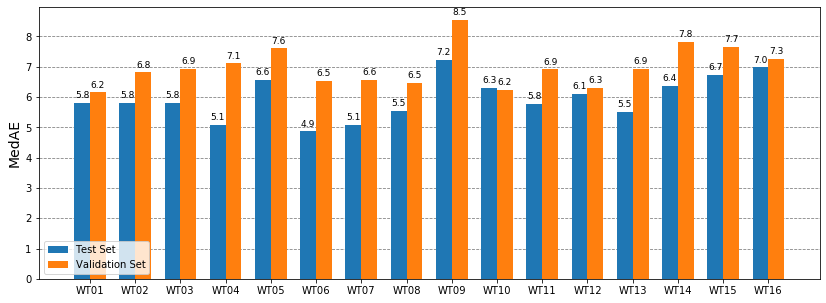

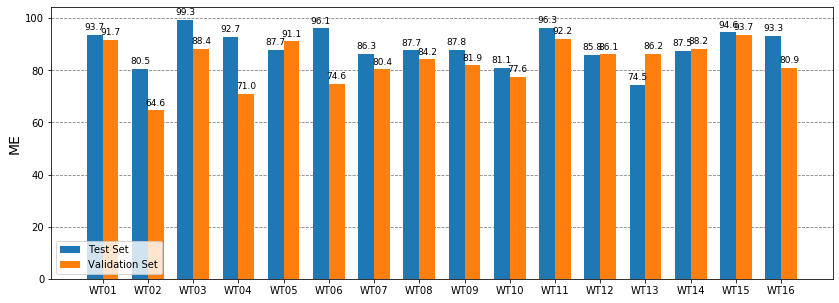

In [88]:
labels = [''.join(i.split('G')) for i in df.columns]
for i,s in enumerate(['R2', 'MAE', 'RMSE', 'MedAE', 'ME']):
    fig, ax = bar_metrics(df.iloc[i],df_val.iloc[i],labels,s,'',figsize=(14,5))
    #fig.savefig('bar_'+s+'.pdf')

#### We need to compare the performance of the direct power prediction from the ANN with a baseline model, we chose to directly predict power from the WRF wind speed, usgin a wind speed-power curve fitted with a gamma curve as baseline

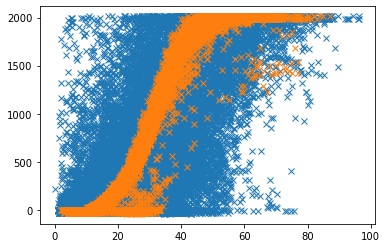

In [89]:
plt.plot(wt_95_retrain[wt]['Ws'].values*3.6,wt_95_retrain[wt]['Power'].values,'x')
plt.plot(wt_95_retrain[wt]['Wind_Speed'].values,wt_95_retrain[wt]['Power'].values,'x')

In [90]:
base1_stats={}
for wt in wt_list:
    gpc = gam(wt_95_retrain[wt]['Wind_Speed'],wt_95_retrain[wt]['Power'])
    dftmp = pd.DataFrame({'Power':wt_95_test[wt]['Power'].values,
                          'Predicted_Power':gpc(wt_95_test[wt]['Ws'].values*3.6)})
    stats = get_stats(dftmp)
    base1_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        base1_stats[wt].append(100*stats[i]/nominal_power[wt])

In [91]:
df_base = pd.DataFrame(base1_stats)

In [92]:
def bar_metrics_3(x1,x2,x3,labels,ylabel,title,width = 0.28,loc = 3,figsize=(14,5)):
    fig,ax = plt.subplots(figsize=figsize)
    xx = np.arange(len(labels))  # the label locations
      # the width of the bars

    rects1 = ax.bar(xx - width, x1, width, label='Test Set')
    rects2 = ax.bar(xx , x2, width, label='Validation Set')
    rects3 = ax.bar(xx + width, x3, width, label='Baseline Model')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel,fontsize = 14)
    ax.set_title(title)
    ax.set_xticks(xx)
    ax.set_xticklabels(labels)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.legend(loc = loc)
    ax = autolabel(ax,rects1)
    ax = autolabel(ax,rects2)
    ax = autolabel(ax,rects3)
    plt.show()
    return fig, ax

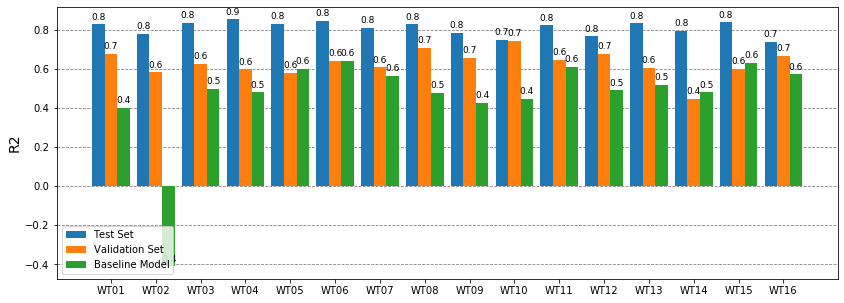

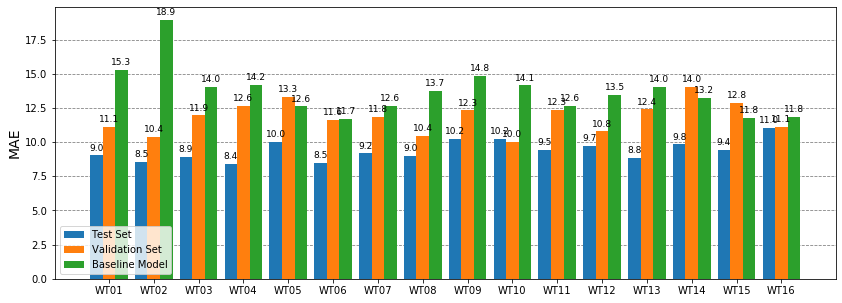

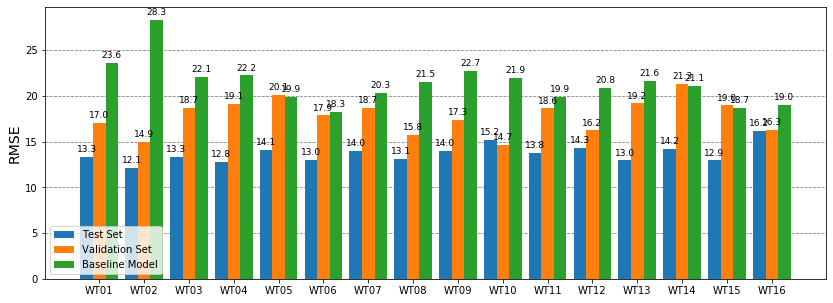

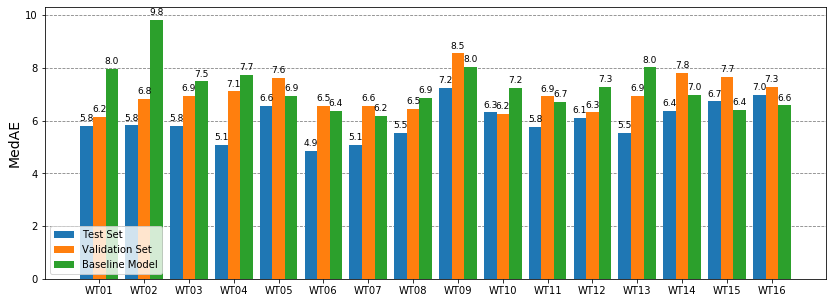

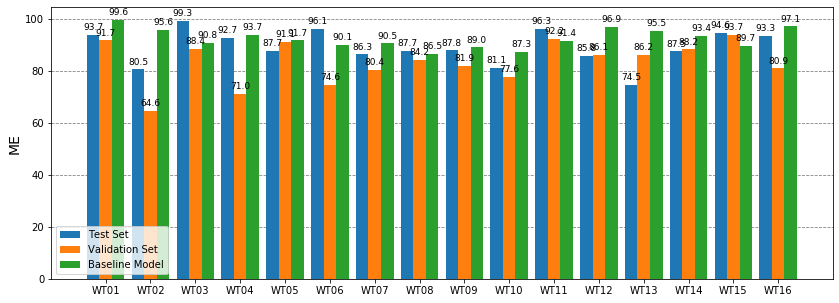

In [93]:
labels = [''.join(i.split('G')) for i in df.columns]
for i,s in enumerate(['R2', 'MAE', 'RMSE', 'MedAE', 'ME']):
    fig, ax = bar_metrics_3(df.iloc[i],df_val.iloc[i],df_base.iloc[i],labels,s,'',figsize=(14,5))
    #fig.savefig('bar_'+s+'.pdf')

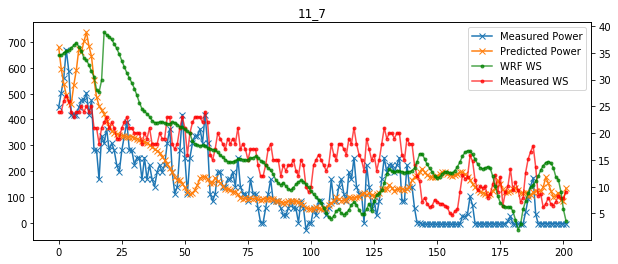

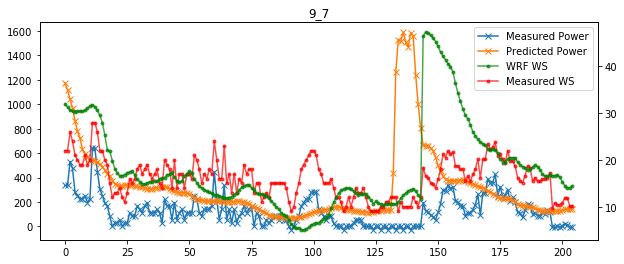

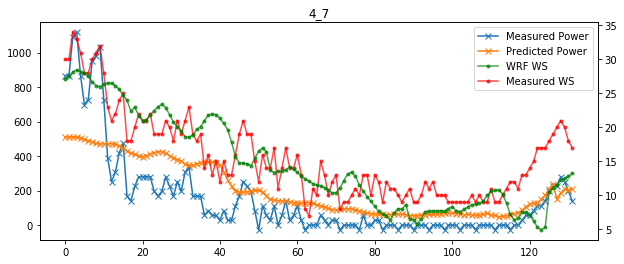

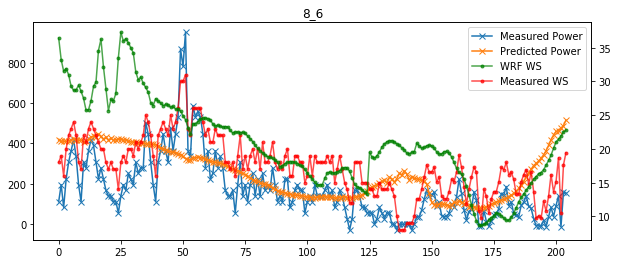

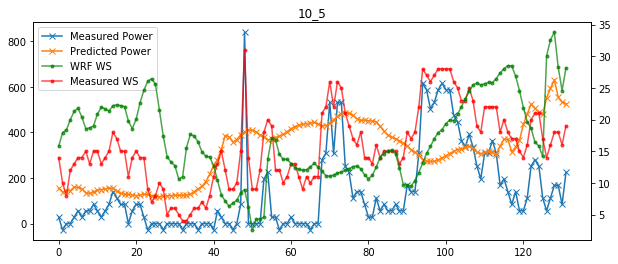

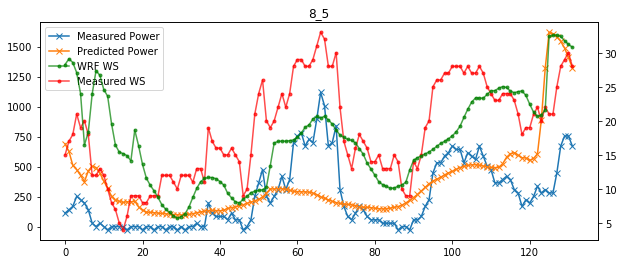

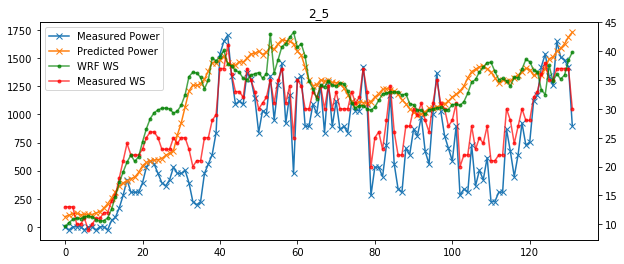

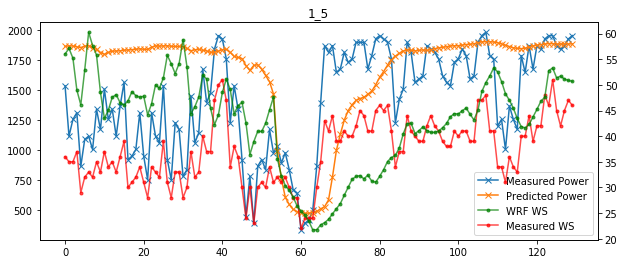

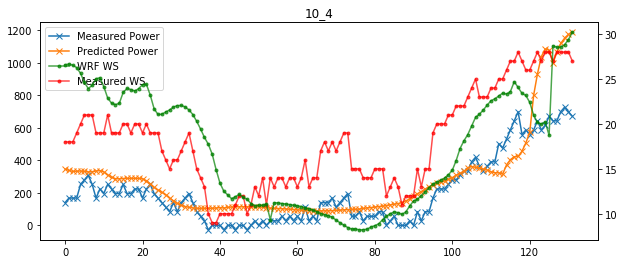

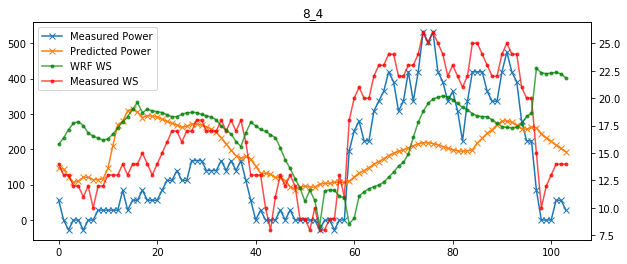

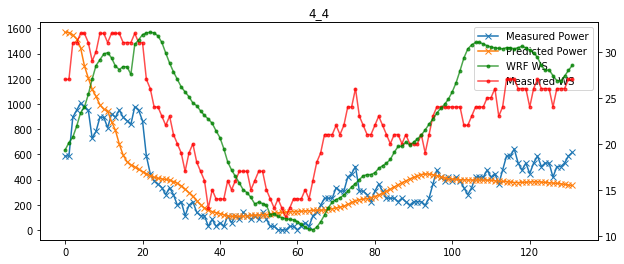

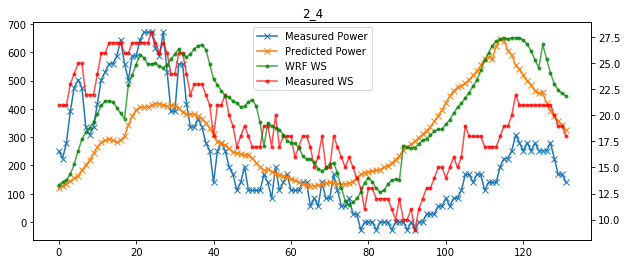

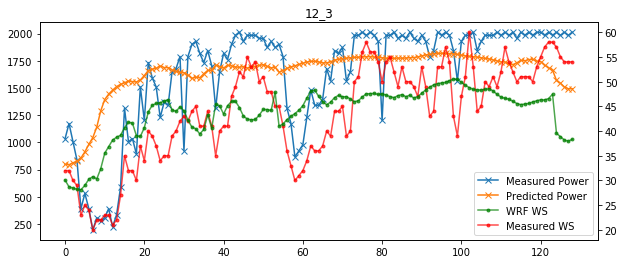

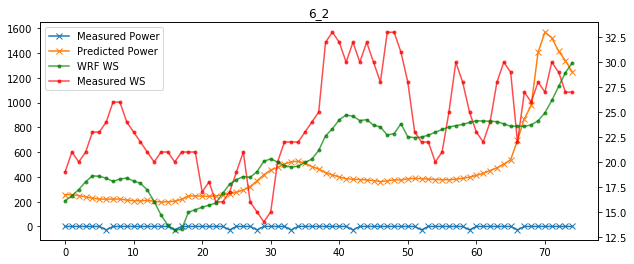

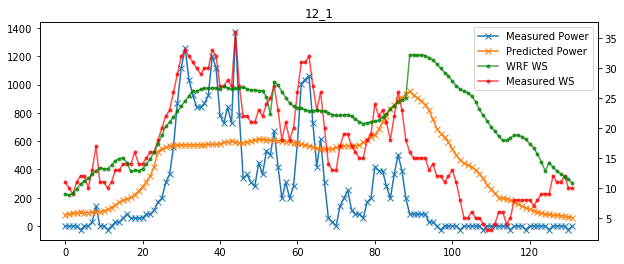

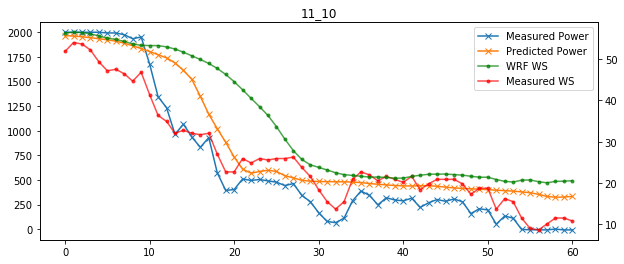

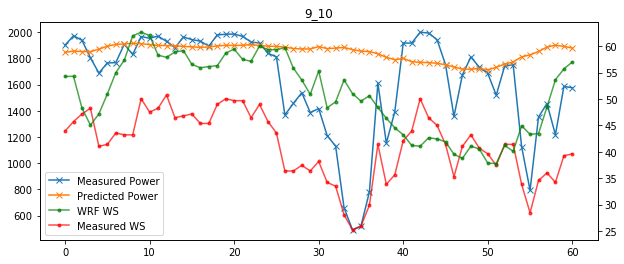

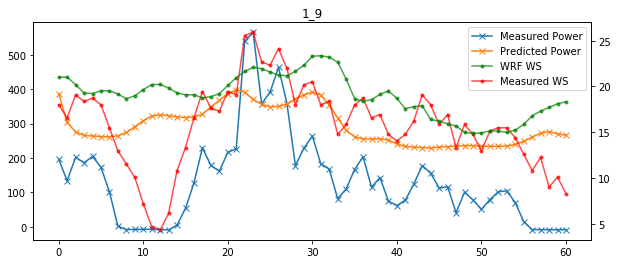

In [94]:
for dm in dfout.Day_Month.unique():
    tmp = dfout[dfout.Day_Month == dm]
    fig,ax = plt.subplots(figsize=(10,4))
    ln1 = ax.plot(tmp.Power.values,'-x',label = 'Measured Power' )
    ln2 = ax.plot(tmp.Predicted_Power.values,'-x',label = 'Predicted Power')

    ax2 = ax.twinx()
    ln4 = ax2.plot(tmp.Wind_Speed.values,'r.-',alpha = 0.7,label = 'Measured WS')
    ln3 = ax2.plot(tmp.Ws.values*3.6,'g.-',alpha = 0.7,label = 'WRF WS')
    
    
    lns = ln1+ln2+ln3+ln4
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)
    plt.title(dm)
    plt.show()

***we can also use a Neural Network to predict wind speed and then use that wind speed to predict power via a wind speed-power curve***

In [113]:
wnn_dict_ws = {}
for wt in wt_list:
    print('----------------------')
    print('------  '+wt+'  ------')
    print('----------------------')
    wnn = WNN.WindNeuralNetwork(wt_95_retrain[wt],wt_150_retrain[wt],var = 'Wind_Speed',
                                features=['Ws', 'Wdir', 'T','P'],
                                look_back=9,
                                time_jump=1,
                                q_weight=1,
                                quantile=0.6,
                                include_tanh = False,
                                patience = 2,
                                epochs = 45,
                                scaler = 'Standard') #Initialize it with the loaded data
    wnn.prep_data()#Prepare the data
    wnn.create_and_fit_model(verbose = 1)  # Create and fit the model  you can set verbose to 1 to see the training evolution
    wnn.predict_and_getmetrics_test()
    print(wnn.stats)
    wnn_dict_ws[wt] = wnn

----------------------
------  WTG01  ------
----------------------
Train on 26259 samples, validate on 4635 samples
Epoch 1/45
26259/26259 [==============================] - 1s 41us/step - loss: 0.2792 - val_loss: 0.2394
Epoch 2/45
26259/26259 [==============================] - 1s 35us/step - loss: 0.2489 - val_loss: 0.2465
Epoch 3/45
26259/26259 [==============================] - 1s 35us/step - loss: 0.2451 - val_loss: 0.2501
[0.7552448938053414, 4.314789628022144, 30.4439617116053, 3.5919264505499484, 27.257840068537995]
----------------------
------  WTG02  ------
----------------------
Train on 26361 samples, validate on 4653 samples
Epoch 1/45
26361/26361 [==============================] - 1s 41us/step - loss: 0.3400 - val_loss: 0.3105
Epoch 2/45
26361/26361 [==============================] - 1s 35us/step - loss: 0.3078 - val_loss: 0.3059
Epoch 3/45
26361/26361 [==============================] - 1s 35us/step - loss: 0.2976 - val_loss: 0.2997
Epoch 4/45
26361/26361 [==============

26202/26202 [==============================] - 1s 37us/step - loss: 0.2166 - val_loss: 0.2361
Epoch 9/45
26202/26202 [==============================] - 1s 36us/step - loss: 0.2130 - val_loss: 0.2080
Epoch 10/45
26202/26202 [==============================] - 1s 36us/step - loss: 0.2098 - val_loss: 0.2125
Epoch 11/45
26202/26202 [==============================] - 1s 37us/step - loss: 0.2037 - val_loss: 0.2112
[0.7934863654276925, 4.229976479226238, 30.328800192103063, 3.3462806000879795, 29.915359088514386]
----------------------
------  WTG09  ------
----------------------
Train on 26342 samples, validate on 4649 samples
Epoch 1/45
26342/26342 [==============================] - 1s 48us/step - loss: 0.2799 - val_loss: 0.2741
Epoch 2/45
26342/26342 [==============================] - 1s 38us/step - loss: 0.2588 - val_loss: 0.2659
Epoch 3/45
26342/26342 [==============================] - 1s 38us/step - loss: 0.2449 - val_loss: 0.2536
Epoch 4/45
26342/26342 [==============================] -

25176/25176 [==============================] - 1s 35us/step - loss: 0.2330 - val_loss: 0.2380
Epoch 8/45
25176/25176 [==============================] - 1s 35us/step - loss: 0.2289 - val_loss: 0.2342
[0.7508946810331663, 4.522316780331312, 36.734083811661485, 3.5446240239075415, 34.755490777408355]


In [124]:
wnn_dict_ws['WTG01'].model.summary()

Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_769 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_770 (Dense)            (None, 53)                4293      
_________________________________________________________________
dense_771 (Dense)            (None, 53)                2862      
_________________________________________________________________
dropout_113 (Dropout)        (None, 53)                0         
_________________________________________________________________
dense_772 (Dense)            (None, 40)                2160      
_________________________________________________________________
leaky_re_lu_113 (LeakyReLU)  (None, 40)                0         
_________________________________________________________________
dense_773 (Dense)            (None, 28)             

In [114]:
## Save the trained models
#with open('wnn_dict_ws_final.pickle', 'wb') as handle:
#    pickle.dump(wnn_dict_ws, handle, protocol=pickle.HIGHEST_PROTOCOL)

------  WTG01  ------
MAE = 4.28
RMSE = 5.48
MedAE = 3.41
ME = 19.25


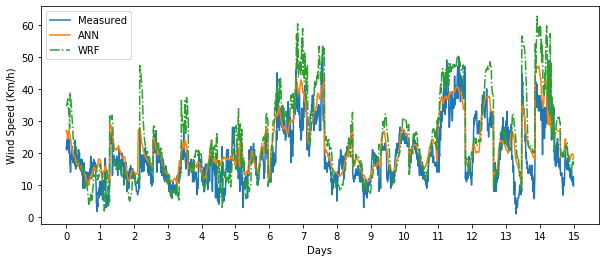

------  WTG02  ------
MAE = 3.76
RMSE = 4.83
MedAE = 3.03
ME = 17.48


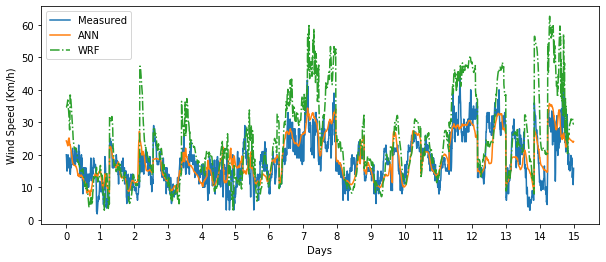

------  WTG03  ------
MAE = 4.3
RMSE = 5.58
MedAE = 3.4
ME = 21.93


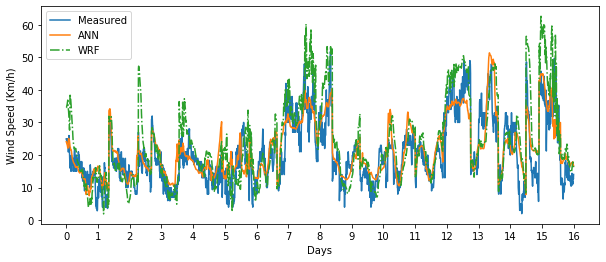

------  WTG04  ------
MAE = 4.18
RMSE = 5.4
MedAE = 3.37
ME = 19.53


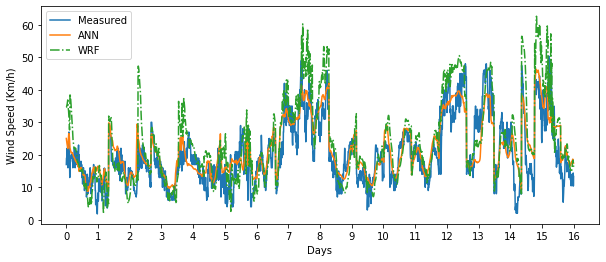

------  WTG05  ------
MAE = 5.39
RMSE = 7.25
MedAE = 3.97
ME = 28.85


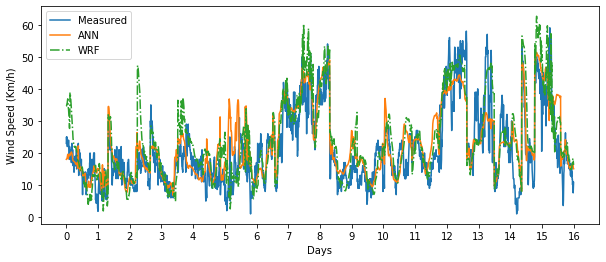

------  WTG06  ------
MAE = 4.63
RMSE = 6.09
MedAE = 3.66
ME = 26.01


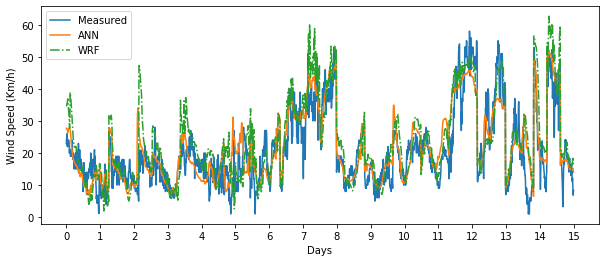

------  WTG07  ------
MAE = 4.68
RMSE = 6.2
MedAE = 3.63
ME = 24.75


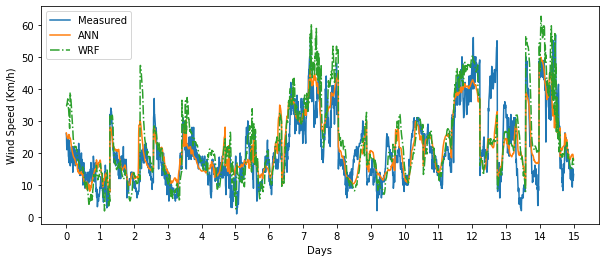

------  WTG08  ------
MAE = 4.54
RMSE = 6.07
MedAE = 3.42
ME = 28.79


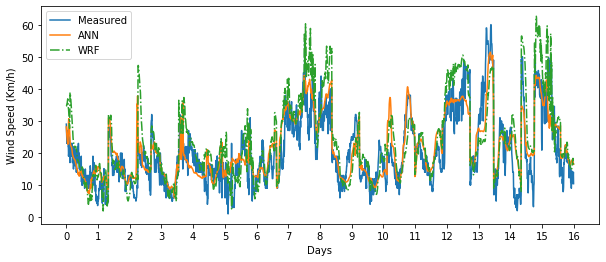

------  WTG09  ------
MAE = 4.39
RMSE = 5.83
MedAE = 3.36
ME = 26.53


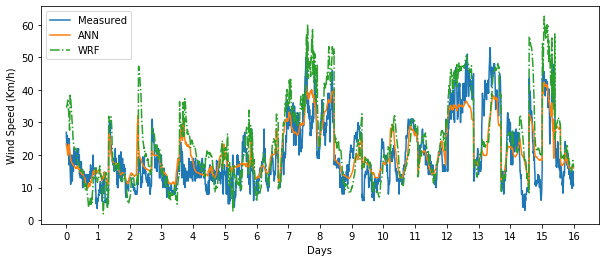

------  WTG10  ------
MAE = 4.59
RMSE = 6.02
MedAE = 3.55
ME = 25.51


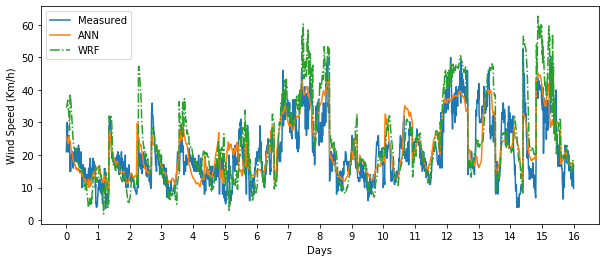

------  WTG11  ------
MAE = 5.02
RMSE = 6.66
MedAE = 4.03
ME = 36.88


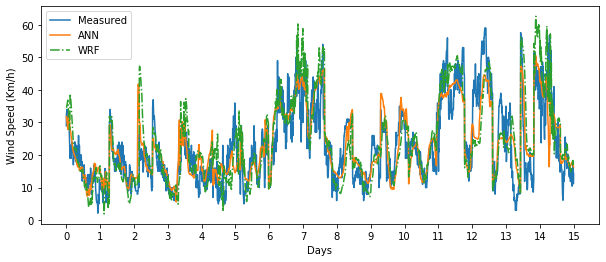

------  WTG12  ------
MAE = 4.16
RMSE = 5.42
MedAE = 3.3
ME = 22.95


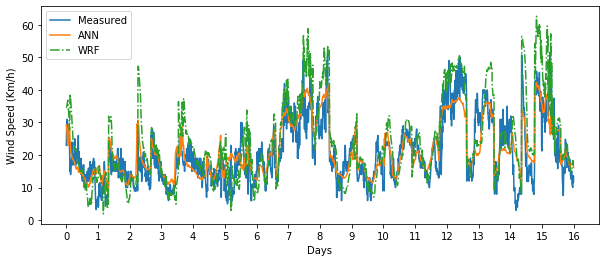

------  WTG13  ------
MAE = 4.44
RMSE = 6.05
MedAE = 3.2
ME = 23.84


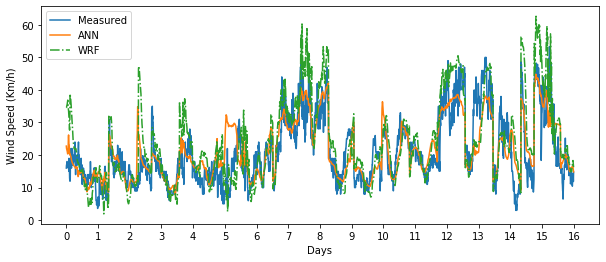

------  WTG14  ------
MAE = 5.03
RMSE = 6.61
MedAE = 3.93
ME = 25.75


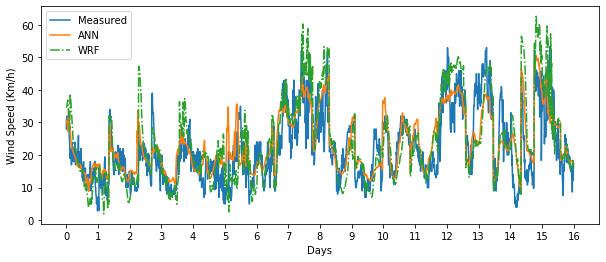

------  WTG15  ------
MAE = 4.78
RMSE = 6.47
MedAE = 3.54
ME = 25.18


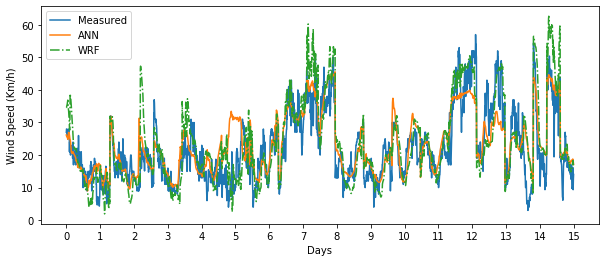

------  WTG16  ------
MAE = 4.68
RMSE = 6.2
MedAE = 3.58
ME = 28.34


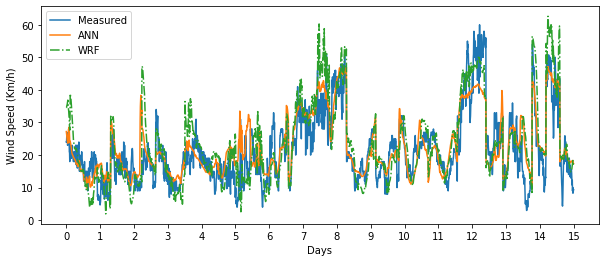

In [130]:
base2_stats={}
for wt in wt_list:
    print('------  '+wt+'  ------')
    dfout = wnn_dict_ws[wt].predict_new_data(wt_95_test[wt],wt_150_test[wt])
    stats = get_stats(dfout,t_name='Wind_Speed')
    for i in list(stats.keys())[1:]:
        print(i +' = '+ str(np.round(stats[i],2)))
    
    
    fig,ax = plt.subplots(figsize=(10,4))
    plt.plot(dfout.Wind_Speed.values,label = 'Measured')
    plt.plot(dfout.Predicted_Power.values,label = 'ANN')
    plt.plot(dfout.Ws.values*3.6,'-.',label = 'WRF')
    plt.ylabel('Wind Speed (Km/h)')
    plt.legend()
    
    xaux = np.arange(0,np.floor(len(dfout.Wind_Speed.values)/(24*6)))
    
    ax.set_xticks(np.linspace(0,len(dfout.Wind_Speed.values),len(xaux)))
    ax.set_xticklabels([int(i) for i in xaux])
    
    plt.xlabel('Days')
    
    plt.show()
    ## From the ANN wind speed interpolate power using the wind power curve
    gpc = gam(wt_95_retrain[wt]['Wind_Speed'],wt_95_retrain[wt]['Power'])
    dftmp = pd.DataFrame({'Power':dfout['Power'].values,
                          'Predicted_Power':gpc(dfout['Predicted_Power'].values)})
    stats = get_stats(dftmp)
    base2_stats[wt] = [stats['R2']]
    for i in list(stats.keys())[1:]:
        base2_stats[wt].append(100*stats[i]/nominal_power[wt])
    
    dfout['Predicted_Power'] = dftmp['Predicted_Power'].values
    
    if wt == 'WTG10':
        fig.savefig('wind_timeplot.pdf',bbox_inches='tight')

#### All the statistics of the four models in one dataframe

In [143]:
df_all_stats = pd.concat([pd.DataFrame(all_stats),
           pd.DataFrame(val_stats),
           pd.DataFrame(base1_stats),
           pd.DataFrame(base2_stats)])
df_all_stats.index = ['R2_test','MAE_test','RMSE_test','MedAE_test','ME_test',
                     'R2_val','MAE_val','RMSE_val','MedAE_val','ME_val',
                     'R2_base','MAE_base','RMSE_base','MedAE_base','ME_base',
                     'R2_hybrid','MAE_hybrid','RMSE_hybrid','MedAE_hybrid','ME_hybrid']
r2_df = df_all_stats.iloc[0::5].T
mae_df = df_all_stats.iloc[1::5].T
rmse_df = df_all_stats.iloc[2::5].T
medae_df = df_all_stats.iloc[3::5].T
me_df = df_all_stats.iloc[4::5].T

In [144]:
def plotbar(df,ylabel,figsize=(14,5)):
    fig,ax = plt.subplots(figsize=(14,5))
    df.plot.bar(ax=ax,rot=0)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.set_ylabel(ylabel)
    plt.legend(loc=1)
    plt.show()
    return fig,ax

In [174]:
rmse_df.RMSE_base-rmse_df.RMSE_hybrid

WTG01     8.413411
WTG02    13.314837
WTG03     6.565812
WTG04     6.440670
WTG05     1.460295
WTG06     4.387200
WTG07     3.849789
WTG08     5.784728
WTG09     5.944507
WTG10     4.681785
WTG11     2.109173
WTG12     5.735036
WTG13     4.256391
WTG14     2.886848
WTG15     1.712193
WTG16     4.126138
dtype: float64

In [175]:
mae_df.MAE_base-mae_df.MAE_hybrid

WTG01    5.053287
WTG02    9.230220
WTG03    3.857983
WTG04    3.828883
WTG05    0.893743
WTG06    2.604326
WTG07    2.360188
WTG08    3.843095
WTG09    4.171897
WTG10    2.919736
WTG11    1.376505
WTG12    3.524844
WTG13    2.913406
WTG14    1.402162
WTG15    0.638389
WTG16    2.152534
dtype: float64

In [171]:
np.mean(rmse_df.RMSE_base-rmse_df.RMSE_val)

3.5831194873688768

In [158]:
mae_df.max()

MAE_test      11.020554
MAE_val       14.037732
MAE_base      18.933544
MAE_hybrid    11.822453
dtype: float64

In [176]:
print(mae_df.std())
print(rmse_df.std())
print(medae_df.std())
print(me_df.std())

MAE_test      0.741938
MAE_val       1.124370
MAE_base      1.763521
MAE_hybrid    0.786796
dtype: float64
RMSE_test      1.008036
RMSE_val       1.866025
RMSE_base      2.382999
RMSE_hybrid    1.324329
dtype: float64
MedAE_test      0.690171
MedAE_val       0.656197
MedAE_base      0.905052
MedAE_hybrid    0.382677
dtype: float64
ME_test      6.653157
ME_val       8.210756
ME_base      3.725459
ME_hybrid    6.540019
dtype: float64


MAE_test       9.387874
MAE_val       11.819801
MAE_base      13.692148
MAE_hybrid    10.518948
dtype: float64


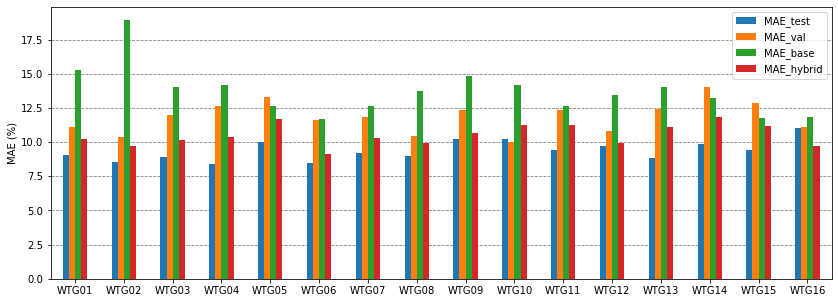

In [145]:
print(mae_df.mean())
fig,ax = plotbar(mae_df,'MAE (%)')
fig.savefig('mae_final.pdf')

RMSE_test      13.715002
RMSE_val       17.790523
RMSE_base      21.373643
RMSE_hybrid    16.269342
dtype: float64


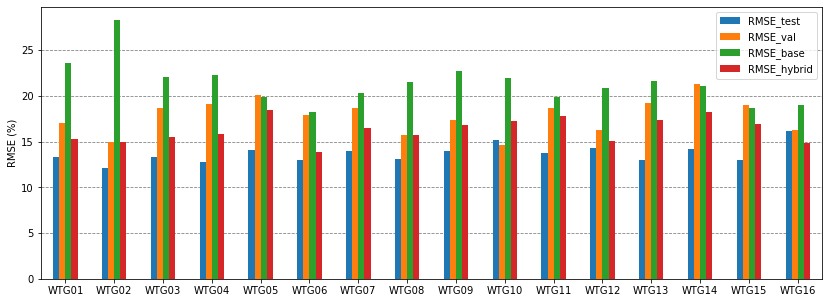

In [146]:
print(rmse_df.mean())
fig,ax = plotbar(rmse_df,'RMSE (%)')
fig.savefig('rmse_final.pdf')

MedAE_test      5.973617
MedAE_val       6.991834
MedAE_base      7.283510
MedAE_hybrid    5.870207
dtype: float64


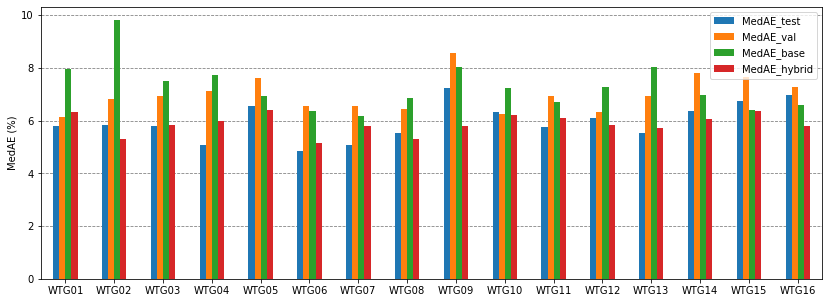

In [147]:
print(medae_df.mean())
fig,ax = plotbar(medae_df,'MedAE (%)')
fig.savefig('medae_final.pdf')

ME_test      89.052631
ME_val       83.296569
ME_base      92.423168
ME_hybrid    81.154583
dtype: float64


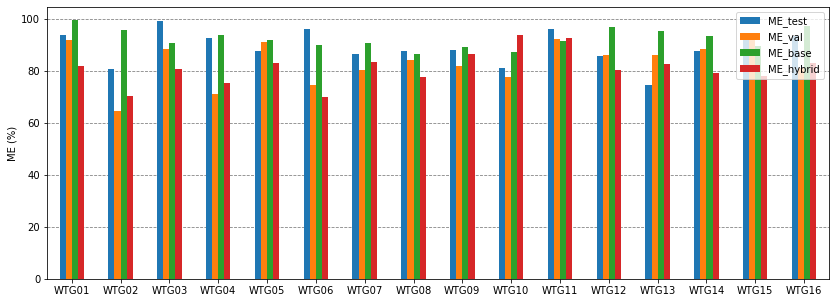

In [148]:
print(me_df.mean())
fig,ax = plotbar(me_df,'ME (%)')
fig.savefig('me_final.pdf')

### Sensitivity analysis

In [85]:
for wt in wt_list:
    wnn = WNN.WindNeuralNetwork(wt_95_retrain[wt],wt_150_retrain[wt],var = 'Power',
                                features=['Ws', 'Wdir', 'T','P'],
                                look_back=9,
                                time_jump=3,
                                q_weight=q_weight,
                                quantile=quantile,
                                include_tanh = include_tanh,
                                patience = 2,
                                epochs = 45,
                                scaler = 'Standard') #Initialize it with the loaded data
    wnn.prep_data()#Prepare the data
    wnn.create_and_fit_model(verbose = 0)  # Create and fit the model 
    wnn.predict_and_getmetrics_test()
    all_stats_tmp[wt] = wnn.stats

In [69]:
print(np.mean([all_stats[wt] for wt in wt_list],axis=0))

[0.8081281062749173, 9.541472038403349, 13.728070553802167, 6.211478234340081, 88.18247703982294]


In [87]:
all_info = []
for include_tanh in [True,False]:
    for look_back in [9,12]:
        for q_weight in [1.25,1.5,1.75]:
            for quantile in [0.5,0.6,0.7]:

                all_stats_tmp = {}
                for wt in wt_list:
                    wnn = WNN.WindNeuralNetwork(wt_95_retrain[wt],wt_150_retrain[wt],var = 'Power',
                                                features=['Ws', 'Wdir', 'T','P'],
                                                look_back=look_back,
                                                time_jump=1,
                                                q_weight=q_weight,
                                                quantile=quantile,
                                                include_tanh = include_tanh,
                                                patience = 2,
                                                epochs = 45,
                                                scaler = 'Standard') #Initialize it with the loaded data
                    wnn.prep_data()#Prepare the data
                    wnn.create_and_fit_model(verbose = 0)  # Create and fit the model 
                    wnn.predict_and_getmetrics_test()
                    all_stats_tmp[wt] = wnn.stats

                for wt in all_stats_tmp:  # convert stats into percentge except for R2
                    tmp = all_stats_tmp[wt]
                    tmp[2] = np.sqrt(tmp[2])
                    all_stats_tmp[wt] = [tmp[0]] + [100*i / nominal_power[wt] for i in tmp[1:]]    

                tmp = list(np.mean([all_stats_tmp[wt] for wt in wt_list],axis=0))    

                all_info.append([include_tanh,look_back,1,q_weight,quantile]+tmp)
                print(all_info[-1])                    

[True, 9, 1, 1.25, 0.5, 0.7858293915593738, 9.82749861663373, 14.465046629918287, 6.069526255734067, 91.82066952924966]
[True, 9, 1, 1.25, 0.6, 0.7867225385589125, 9.897115100268572, 14.435273477733466, 6.238880226650053, 91.13041431806298]
[True, 9, 1, 1.25, 0.7, 0.7892130301818499, 9.890864037202897, 14.354738384442035, 6.195566618081055, 91.12244479222099]
[True, 9, 1, 1.5, 0.5, 0.8016668432853684, 9.594235042610466, 13.956175620598195, 6.171162818126419, 89.62881731426101]
[True, 9, 1, 1.5, 0.6, 0.7951810170735738, 9.880045981328614, 14.171778291079304, 6.394596591517097, 89.86021746703975]
[True, 9, 1, 1.5, 0.7, 0.7907221536314535, 9.761320098643719, 14.328462537768218, 6.079529870689708, 90.85969736457331]
[True, 9, 1, 1.75, 0.5, 0.7765089766724483, 10.370443804522747, 14.791700872537948, 6.840992404910784, 90.32742737950586]
[True, 9, 1, 1.75, 0.6, 0.7855583802032593, 10.13158821833925, 14.5205409257967, 6.536154092175133, 89.86906077066598]
[True, 9, 1, 1.75, 0.7, 0.78580385319

In [137]:
all_info=[[True, 9, 1, 1.25, 0.5, 0.7858293915593738, 9.82749861663373, 14.465046629918287, 6.069526255734067, 91.82066952924966],
[True, 9, 1, 1.25, 0.6, 0.7867225385589125, 9.897115100268572, 14.435273477733466, 6.238880226650053, 91.13041431806298],
[True, 9, 1, 1.25, 0.7, 0.7892130301818499, 9.890864037202897, 14.354738384442035, 6.195566618081055, 91.12244479222099],
[True, 9, 1, 1.5, 0.5, 0.8016668432853684, 9.594235042610466, 13.956175620598195, 6.171162818126419, 89.62881731426101],
[True, 9, 1, 1.5, 0.6, 0.7951810170735738, 9.880045981328614, 14.171778291079304, 6.394596591517097, 89.86021746703975],
[True, 9, 1, 1.5, 0.7, 0.7907221536314535, 9.761320098643719, 14.328462537768218, 6.079529870689708, 90.85969736457331],
[True, 9, 1, 1.75, 0.5, 0.7765089766724483, 10.370443804522747, 14.791700872537948, 6.840992404910784, 90.32742737950586],
[True, 9, 1, 1.75, 0.6, 0.7855583802032593, 10.13158821833925, 14.5205409257967, 6.536154092175133, 89.86906077066598],
[True, 9, 1, 1.75, 0.7, 0.785803853197562, 9.919932241335903, 14.502007700533111, 6.083187436843307, 90.7865843156303],
[True, 12, 1, 1.25, 0.5, 0.7970555392854286, 9.712987706113557, 14.169236522654362, 6.101477374486446, 88.67138797262525],
[True, 12, 1, 1.25, 0.6, 0.8119110916461157, 9.147417867770983, 13.616920721642844, 5.571294014576114, 89.39500929949364],
[True, 12, 1, 1.25, 0.7, 0.8053642483087013, 9.240282816299466, 13.845145602639423, 5.540942053827027, 89.0107339150581],
[True, 12, 1, 1.5, 0.5, 0.8176330184609165, 9.105813371300748, 13.374934734601847, 5.731843234197413, 87.23326066387787],
[True, 12, 1, 1.5, 0.6, 0.7964091181793056, 9.742479607625004, 14.170120946699834, 6.111572134842383, 88.88572026879278],
[True, 12, 1, 1.5, 0.7, 0.7993876387890875, 9.52895217609889, 14.051998203690287, 5.822483194504914, 88.86507819313178],
[True, 12, 1, 1.75, 0.5, 0.7942304863601184, 9.83591425840855, 14.253269125554345, 6.300408103604233, 88.37920457608823],
[True, 12, 1, 1.75, 0.6, 0.8020199630403807, 9.671730908755553, 13.959801774300967, 6.123432595085875, 86.92489642013528],
[True, 12, 1, 1.75, 0.7, 0.8052232477120354, 9.514596748785802, 13.869028231546348, 5.920837939424757, 87.45762153673276],
[False, 9, 1, 1.25, 0.5, 0.7843675487050858, 10.357758481305986, 14.53203139489463, 7.11530718000709, 88.78330777242724],
[False, 9, 1, 1.25, 0.6, 0.7838929210180579, 10.266639960644598, 14.537776417011948, 6.90139469499295, 91.62638852179815],
[False, 9, 1, 1.25, 0.7, 0.7891366468625434, 10.119982783012057, 14.379140778728463, 6.682258733664638, 91.06605537301922],
[False, 9, 1, 1.5, 0.5, 0.7744022995197551, 10.688449741769587, 14.839700996263518, 7.595332476810938, 90.46439393789878],
[False, 9, 1, 1.5, 0.6, 0.7845810615093081, 10.380310443404788, 14.507266621349116, 7.1740114633672745, 87.86646480205947],
[False, 9, 1, 1.5, 0.7, 0.8013945875830578, 9.955913197257665, 13.954865414385633, 6.850296490165437, 93.64574085847626],
[False, 9, 1, 1.75, 0.5, 0.7804369213116145, 10.808766452994966, 14.670561416706194, 7.966072710550394, 88.35776493491156],
[False, 9, 1, 1.75, 0.6, 0.7855686336506416, 10.467229251354201, 14.481060173826249, 7.430008835499453, 92.37432223166248],
[False, 9, 1, 1.75, 0.7, 0.7669462271867005, 11.057079184469497, 15.082025665677843, 7.9055546776082295, 87.89743894421521],
[False, 12, 1, 1.25, 0.5, 0.7910882384319791, 10.244904476362098, 14.334428418717351, 7.1318195286169175, 87.33268262201142],
[False, 12, 1, 1.25, 0.6, 0.803733877497212, 9.806457187384353, 13.896480871705473, 6.650468554110805, 88.76363528449772],
[False, 12, 1, 1.25, 0.7, 0.7914433091008058, 10.166442899718575, 14.340349276720755, 6.867844230829026, 88.69006119552715],
[False, 12, 1, 1.5, 0.5, 0.7857577126947856, 10.504890214091033, 14.517062573772728, 7.48687076697963, 91.16020546503563],
[False, 12, 1, 1.5, 0.6, 0.8023434702487712, 9.841150435209428, 13.958096903782637, 6.5942667193971065, 86.00603560059928],
[False, 12, 1, 1.5, 0.7, 0.7952900960804697, 9.847622809541111, 14.147253165989078, 6.44239663299733, 88.07338053020526],
[False, 12, 1, 1.75, 0.5, 0.8004906649940043, 10.173206140864519, 14.041051770514132, 7.282755539879668, 85.204973668374],
[False, 12, 1, 1.75, 0.6, 0.8055599584860977, 9.797701918119584, 13.815812636679384, 6.717907373520287, 92.40808776401043],
[False, 12, 1, 1.75, 0.7, 0.7860842553140495, 10.309273723188614, 14.514052609468234, 6.950930638435207, 85.452517358223]]

In [138]:
dfa = pd.DataFrame(data = all_info,
                   columns = ['include_tanh','look_back','time_jump','q_weight','quantile','R2','MAE','RMSE','MedAE','ME'])

In [139]:
dfa.style.highlight_min(color = 'lightgreen',  
                       axis = 0,subset = ['MAE','RMSE','MedAE','ME']) 

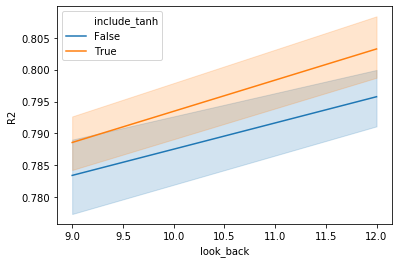

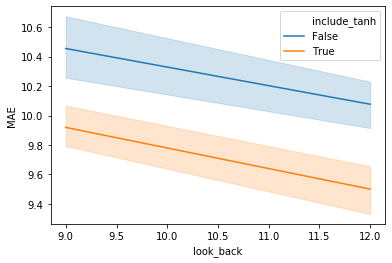

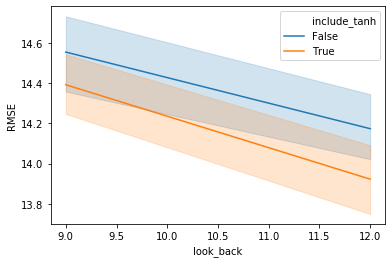

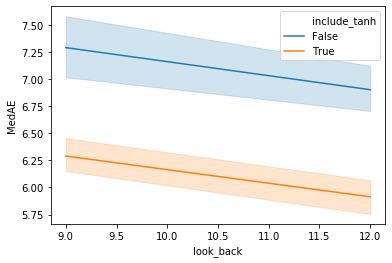

In [155]:
for m in ['R2','MAE','RMSE','MedAE']:
    fig ,ax = plt.subplots()
    sns.lineplot(data = dfa, y = m ,x = 'look_back',hue = 'include_tanh',legend ='full')
    fig.savefig('figures\\'+m+'_one.png',dpi=150,bbox_inches='tight')

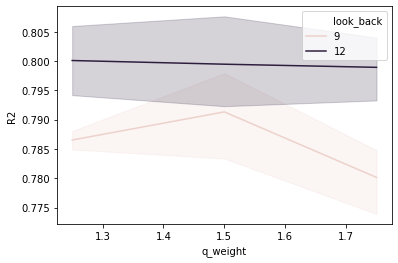

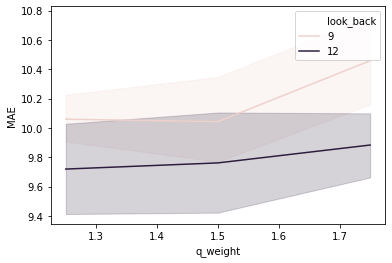

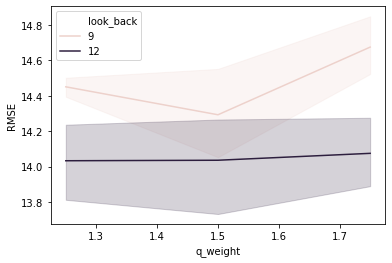

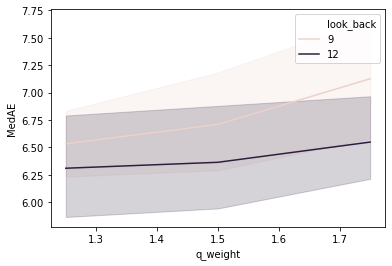

In [156]:
for m in ['R2','MAE','RMSE','MedAE']:
    fig ,ax = plt.subplots()
    sns.lineplot(data = dfa, y = m ,x = 'q_weight',hue = 'look_back',legend ='full')
    fig.savefig('figures\\'+m+'_two.png',dpi=150,bbox_inches='tight')

In [ ]:
[True, 6, 1, 1.25, 0.5, 0.7700573381409777, 10.413532324727868, 14.953788211532313, 6.715839271981819, 93.00920986720357]
[True, 6, 1, 1.25, 0.6, 0.7629818391760936, 10.546102472031563, 15.216894095126406, 6.757506183535683, 93.0511695591266]
[True, 6, 1, 1.25, 0.7, 0.7757802503560617, 10.189976244123619, 14.80725172419567, 6.516408282968213, 93.20902140345378]
[True, 6, 1, 1.5, 0.5, 0.7711924417883537, 10.534813524620088, 14.969372603055694, 7.001234778063011, 92.09631592515314]
[True, 6, 1, 1.5, 0.6, 0.7774935527380551, 10.323196203440407, 14.733477203483776, 6.751174479214278, 93.65308906621951]
[True, 6, 1, 1.5, 0.7, 0.7726889304471751, 10.385673952548832, 14.89134153830529, 6.658363847415791, 92.27543934903142]
[True, 6, 1, 1.75, 0.5, 0.7622702728587386, 10.941693005177186, 15.244294281353358, 7.52335266153782, 91.98751495102859]
[True, 6, 1, 1.75, 0.6, 0.76673735582911, 10.604467702426366, 15.092604815815882, 6.920997829355133, 92.42568725115159]
[True, 6, 1, 1.75, 0.7, 0.7647707571597245, 10.592864357652934, 15.169033942590108, 6.788101942348835, 92.80914864569927]
[True, 6, 2, 1.25, 0.5, 0.7587798566783941, 10.674427382197727, 15.357787649268127, 6.834529626573905, 94.34004907078213]
[True, 6, 2, 1.25, 0.6, 0.7660231451850223, 10.60815757648288, 15.123567924928626, 6.938318074764991, 93.31575607298618]
[True, 6, 2, 1.25, 0.7, 0.7633633742729755, 10.526992785745996, 15.20389268649371, 6.677137173220553, 93.61637289529796]
[True, 6, 2, 1.5, 0.5, 0.7623128087486534, 10.683751174038566, 15.247127902707623, 7.0150374842485705, 93.28719755218808]
[True, 6, 2, 1.5, 0.6, 0.7620869291181056, 10.707313693182547, 15.239902274755009, 6.97832629015705, 92.91712028639108]
[True, 6, 2, 1.5, 0.7, 0.7568621034589779, 10.810694997124479, 15.39442465717241, 7.046201912475991, 92.04528893254977]
[True, 6, 2, 1.75, 0.5, 0.757703542019027, 10.861266279679441, 15.347548429631999, 7.320993727404228, 93.93528293237237]
[True, 6, 2, 1.75, 0.6, 0.7519393465508339, 11.165372718420986, 15.562143804574523, 7.585706161834457, 92.53458574871462]
[True, 6, 2, 1.75, 0.7, 0.7578794264771527, 10.95256427884004, 15.37580025433099, 7.283157873905552, 92.9791745763755]
[True, 6, 3, 1.25, 0.5, 0.7595269973368177, 10.844974015543299, 15.33969386321514, 7.187309507654197, 92.12069844590347]
[True, 6, 3, 1.25, 0.6, 0.7552368827344939, 10.93369520018622, 15.471071766412239, 7.27447790744402, 92.42303752521616]
[True, 6, 3, 1.25, 0.7, 0.7603861194960465, 10.603969716670171, 15.310361808978284, 6.710045656182503, 93.92032997901846]
[True, 6, 3, 1.5, 0.5, 0.7543377571445242, 10.998989960651969, 15.493879562772895, 7.381060831552192, 92.61891121490918]
[True, 6, 3, 1.5, 0.6, 0.7535881754796835, 11.142087556175795, 15.535314316136583, 7.557097188211441, 91.18896017928903]
[True, 6, 3, 1.5, 0.7, 0.7506284939793862, 11.06099319175524, 15.621104582751638, 7.283777925702877, 92.40898045921224]
[True, 6, 3, 1.75, 0.5, 0.7470758043152881, 11.552964090460137, 15.723652767982019, 8.353601020993874, 91.89436327188331]
[True, 6, 3, 1.75, 0.6, 0.7539541493839541, 11.164102022645746, 15.516218729103652, 7.544810679725298, 92.13074551910461]
[True, 6, 3, 1.75, 0.7, 0.7513457165764561, 11.21355566250059, 15.595036975201308, 7.533735399370842, 91.96565084083592]
[True, 9, 1, 1.25, 0.5, 0.7967687516833009, 9.691172658194343, 14.134531207115867, 6.110223578281541, 90.74652706691715]
[True, 9, 1, 1.25, 0.6, 0.7977467244189134, 9.543130761631446, 14.059076120181173, 5.846925244022347, 90.73097596370854]
[True, 9, 1, 1.25, 0.7, 0.7985635125167724, 9.448698895239714, 14.057355559181236, 5.685597341929316, 90.89495128432905]
[True, 9, 1, 1.5, 0.5, 0.7935374297229287, 9.794774831427532, 14.225370905079318, 6.304218625609679, 90.51414596532537]
[True, 9, 1, 1.5, 0.6, 0.7900030366096468, 9.96191215998233, 14.34846551612908, 6.380279700979443, 91.10537174633654]
[True, 9, 1, 1.5, 0.7, 0.7869302217065605, 9.844591275802445, 14.42834234910991, 6.0373052301182, 92.13124517617729]
[True, 9, 1, 1.75, 0.5, 0.7908608457848404, 9.908741107954958, 14.248803894349422, 6.48023676946316, 89.04046813453373]
[True, 9, 1, 1.75, 0.6, 0.7770352442681483, 10.243035136127103, 14.786425410513726, 6.579953498673264, 89.84544483506515]
[True, 9, 1, 1.75, 0.7, 0.7981582734574252, 9.817657207040014, 14.072133659480196, 6.280010923511649, 88.95140188051303]

In [ ]:
df = pd.DataFrame([[True, 6, 1, 1.25, 0.5, 0.7700573381409777, 10.413532324727868, 14.953788211532313, 6.715839271981819, 93.00920986720357]
[True, 6, 1, 1.25, 0.6, 0.7629818391760936, 10.546102472031563, 15.216894095126406, 6.757506183535683, 93.0511695591266]
[True, 6, 1, 1.25, 0.7, 0.7757802503560617, 10.189976244123619, 14.80725172419567, 6.516408282968213, 93.20902140345378]
[True, 6, 1, 1.5, 0.5, 0.7711924417883537, 10.534813524620088, 14.969372603055694, 7.001234778063011, 92.09631592515314]
[True, 6, 1, 1.5, 0.6, 0.7774935527380551, 10.323196203440407, 14.733477203483776, 6.751174479214278, 93.65308906621951]
[True, 6, 1, 1.5, 0.7, 0.7726889304471751, 10.385673952548832, 14.89134153830529, 6.658363847415791, 92.27543934903142]
[True, 6, 1, 1.75, 0.5, 0.7622702728587386, 10.941693005177186, 15.244294281353358, 7.52335266153782, 91.98751495102859]
[True, 6, 1, 1.75, 0.6, 0.76673735582911, 10.604467702426366, 15.092604815815882, 6.920997829355133, 92.42568725115159]
[True, 6, 1, 1.75, 0.7, 0.7647707571597245, 10.592864357652934, 15.169033942590108, 6.788101942348835, 92.80914864569927]
[True, 6, 2, 1.25, 0.5, 0.7587798566783941, 10.674427382197727, 15.357787649268127, 6.834529626573905, 94.34004907078213]
[True, 6, 2, 1.25, 0.6, 0.7660231451850223, 10.60815757648288, 15.123567924928626, 6.938318074764991, 93.31575607298618]
[True, 6, 2, 1.25, 0.7, 0.7633633742729755, 10.526992785745996, 15.20389268649371, 6.677137173220553, 93.61637289529796]
[True, 6, 2, 1.5, 0.5, 0.7623128087486534, 10.683751174038566, 15.247127902707623, 7.0150374842485705, 93.28719755218808]
[True, 6, 2, 1.5, 0.6, 0.7620869291181056, 10.707313693182547, 15.239902274755009, 6.97832629015705, 92.91712028639108]
[True, 6, 2, 1.5, 0.7, 0.7568621034589779, 10.810694997124479, 15.39442465717241, 7.046201912475991, 92.04528893254977]
[True, 6, 2, 1.75, 0.5, 0.757703542019027, 10.861266279679441, 15.347548429631999, 7.320993727404228, 93.93528293237237]
[True, 6, 2, 1.75, 0.6, 0.7519393465508339, 11.165372718420986, 15.562143804574523, 7.585706161834457, 92.53458574871462]
[True, 6, 2, 1.75, 0.7, 0.7578794264771527, 10.95256427884004, 15.37580025433099, 7.283157873905552, 92.9791745763755]
[True, 6, 3, 1.25, 0.5, 0.7595269973368177, 10.844974015543299, 15.33969386321514, 7.187309507654197, 92.12069844590347]
[True, 6, 3, 1.25, 0.6, 0.7552368827344939, 10.93369520018622, 15.471071766412239, 7.27447790744402, 92.42303752521616]
[True, 6, 3, 1.25, 0.7, 0.7603861194960465, 10.603969716670171, 15.310361808978284, 6.710045656182503, 93.92032997901846]
[True, 6, 3, 1.5, 0.5, 0.7543377571445242, 10.998989960651969, 15.493879562772895, 7.381060831552192, 92.61891121490918]
[True, 6, 3, 1.5, 0.6, 0.7535881754796835, 11.142087556175795, 15.535314316136583, 7.557097188211441, 91.18896017928903]
[True, 6, 3, 1.5, 0.7, 0.7506284939793862, 11.06099319175524, 15.621104582751638, 7.283777925702877, 92.40898045921224]
[True, 6, 3, 1.75, 0.5, 0.7470758043152881, 11.552964090460137, 15.723652767982019, 8.353601020993874, 91.89436327188331]
[True, 6, 3, 1.75, 0.6, 0.7539541493839541, 11.164102022645746, 15.516218729103652, 7.544810679725298, 92.13074551910461]
[True, 6, 3, 1.75, 0.7, 0.7513457165764561, 11.21355566250059, 15.595036975201308, 7.533735399370842, 91.96565084083592]])